In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as snsbb


In [2]:
#Read Budget data on precinct level
summary_df = pd.read_csv('Research_Firearm/summary_test.csv')

# Read census data
merged_pivot = pd.read_csv('Research_Firearm/merged_pivot_test.csv')

# Add two feature "Violent Crime" and "Property Crime"
table_for_tableau = merged_pivot.copy()
# Create 'Violent Crime' column
table_for_tableau['Violent Crime'] = table_for_tableau['FELONY ASSAULT'] + table_for_tableau['MURDER & NON NEGL. MANSLAUGHTER'] + table_for_tableau['RAPE'] + table_for_tableau['ROBBERY']
# Create 'Property Crime' column
table_for_tableau['Property Crime'] = table_for_tableau['GRAND LARCENY'] + table_for_tableau['GRAND LARCENY OF MOTOR VEHICLE'] + table_for_tableau['BURGLARY']

# Calculate the sum of 'Violent Crime' and 'Property Crime'
table_for_tableau['Calculated Total'] = table_for_tableau['Violent Crime'] + table_for_tableau['Property Crime']
# Compare with 'TOTAL SEVEN MAJOR FELONY OFFENSES' and create a validation column
table_for_tableau['Validation'] = table_for_tableau['Calculated Total'] == table_for_tableau['TOTAL SEVEN MAJOR FELONY OFFENSES']

shooting_historic = pd.read_csv('Research_Firearm/NYPD_Shooting_Incident_Data__Historic_.csv')
shooting_historic['Year'] = pd.to_datetime(shooting_historic['OCCUR_DATE']).dt.year
shooting_historic = shooting_historic[['INCIDENT_KEY','Year','PRECINCT']]
shooting_historic = shooting_historic.drop_duplicates()
# Count the number of shootings by Year and PRECINCT
shootings_count = shooting_historic.groupby(['Year', 'PRECINCT']).size().reset_index(name='Shootings')
# Merge with merged_pivot table
merged_data = pd.merge(merged_pivot, shootings_count, how='left', left_on=['Year', 'Precinct'], right_on=['Year', 'PRECINCT'])
# Fill NaN values in the Shootings column with 0 (assuming that NaN means there were no shootings)
merged_data['Shootings'].fillna(0, inplace=True)
# Drop the redundant PRECINCT column
merged_data.drop('PRECINCT', axis=1, inplace=True)

# Calculate yearly totals
yearly_totals = merged_data.groupby('Year').sum().reset_index()
# List of metrics for which want to calculate yearly totals
metrics = ['BURGLARY', 'FELONY ASSAULT', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 
           'MURDER & NON NEGL. MANSLAUGHTER', 'RAPE', 'ROBBERY', 'TOTAL SEVEN MAJOR FELONY OFFENSES', 
           'Shootings', 'Budget']
# Rename columns to *_by_year
yearly_totals = yearly_totals.rename(columns={metric: f"{metric.lower()}_by_year" for metric in metrics})
# Merge yearly totals with merged_data
merged_data = pd.merge(merged_data, yearly_totals[['Year'] + [f"{metric.lower()}_by_year" for metric in metrics]], 
                       on='Year', how='left')
# Now, calculate the percentage-based columns, for example:
merged_data['Burglary_pct'] = merged_data['BURGLARY'] / merged_data['burglary_by_year']
# And the per capita rate:
merged_data['Burglary_per_capita'] = merged_data['BURGLARY'] / merged_data['Population_2010']
# List of metrics for which to calculate yearly totals and per capita rates
metrics = ['FELONY ASSAULT', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 
           'MURDER & NON NEGL. MANSLAUGHTER', 'RAPE', 'ROBBERY', 'TOTAL SEVEN MAJOR FELONY OFFENSES', 
           'Shootings', 'Budget']
# Loop through each metric
for metric in metrics:
    # Compute the per capita rate
    per_capita_col_name = f"{metric}_per_capita"
    merged_data[per_capita_col_name] = merged_data[metric] / merged_data['Population_2010']    
    # Compute the percentage-based rate
    pct_col_name = f"{metric}_pct"
    yearly_col_name = f"{metric.lower()}_by_year"
    merged_data[pct_col_name] = merged_data[metric] / merged_data[yearly_col_name]
    
pre_ts_analysis = pd.read_csv('Research_Firearm/pre_ts_analysis.csv')
pre_ts_analysis_pre_v = pre_ts_analysis[['Year', 'Precinct', 'Budget', 'BURGLARY', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 'TOTAL SEVEN MAJOR FELONY OFFENSES', 'Population_Year']]
# Grouping by 'Year' and summing 'TOTAL SEVEN MAJOR FELONY OFFENSES'
total_seven_per_year = pre_ts_analysis_pre_v.groupby('Year')['TOTAL SEVEN MAJOR FELONY OFFENSES'].sum().reset_index(name='Total Seven for Year')
# Merging this back into the original DataFrame
pre_ts_analysis_pre_v_y = pre_ts_analysis_pre_v.merge(total_seven_per_year, on='Year')
# Grouping by 'Year' and calculating the total budget for each year
budget_per_year = pre_ts_analysis_pre_v.groupby('Year')['Budget'].sum().reset_index(name='Budget for Year')
# Grouping by 'Year' and calculating the total property crimes for each year
property_crimes_per_year = pre_ts_analysis_pre_v.groupby('Year')[['BURGLARY', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE']].sum()
property_crimes_per_year['Property Crime for Year'] = property_crimes_per_year.sum(axis=1)
property_crimes_per_year = property_crimes_per_year.reset_index()
# Calculating 'Violent Crime for Year'
total_crimes_per_year = pre_ts_analysis_pre_v.groupby('Year')['TOTAL SEVEN MAJOR FELONY OFFENSES'].sum().reset_index()
violent_crimes_per_year = pd.merge(total_crimes_per_year, property_crimes_per_year[['Year', 'Property Crime for Year']], on='Year')
violent_crimes_per_year['Violent Crime for Year'] = violent_crimes_per_year['TOTAL SEVEN MAJOR FELONY OFFENSES'] - violent_crimes_per_year['Property Crime for Year']
# Merging all results into final_df
pre_ts_analysis_pre_v_test = pd.merge(budget_per_year, property_crimes_per_year[['Year', 'Property Crime for Year']], on='Year')
pre_ts_analysis_pre_v_test = pd.merge(pre_ts_analysis_pre_v_test, violent_crimes_per_year[['Year', 'Violent Crime for Year']], on='Year')
pre_ts_analysis_no_2022 = pre_ts_analysis[pre_ts_analysis['Year'] != 2022]

# Get all columns ending with '_pct' or '_per_capita'
cols_to_lag = [col for col in pre_ts_analysis.columns if col.endswith('_pct') or col.endswith('_per_capita')]
# Loop through the columns and create a lag-1 column for each
for col in cols_to_lag:
    lag_col_name = col + '_lag1'  # Name of the new lag column
    pre_ts_analysis[lag_col_name] = pre_ts_analysis.groupby('Precinct')[col].shift(1)

In [3]:
# update new population data
# List of metrics for which you want to calculate yearly totals and per capita rates
metrics = ['FELONY ASSAULT', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 
           'MURDER & NON NEGL. MANSLAUGHTER', 'RAPE', 'ROBBERY', 'TOTAL SEVEN MAJOR FELONY OFFENSES', 
           'Shootings', 'Budget']

# Loop through each metric
for metric in metrics:
    # Compute the per capita rate using the updated Population_Year column
    per_capita_col_name = f"{metric}_per_capita"
    pre_ts_analysis[per_capita_col_name] = pre_ts_analysis[metric] / pre_ts_analysis['Population_Year']

# List of crimes to compute per_capita_lag1_pct for
crimes = ['Burglary', 'FELONY ASSAULT', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 
          'MURDER & NON NEGL. MANSLAUGHTER', 'RAPE', 'ROBBERY', 'Shootings']

for crime in crimes:
    column_name = f"{crime}_per_capita_lag1"
    total_column_name = f"NYC_{column_name}_total"
    
    # 1. Compute total crime_per_capita_lag1 for each year across all precincts
    nyc_totals = pre_ts_analysis.groupby('Year')[column_name].sum().reset_index()
    nyc_totals = nyc_totals.rename(columns={column_name: total_column_name})
    
    # 2. Merge the total back to the pre_ts_analysis DataFrame
    pre_ts_analysis = pd.merge(pre_ts_analysis, nyc_totals, on='Year', how='left')
    
    # 3. Compute the percentage
    pct_column_name = f"{crime}_per_capita_lag1_pct"
    pre_ts_analysis[pct_column_name] = (pre_ts_analysis[column_name] / pre_ts_analysis[total_column_name]) 
    
    # Drop the NYC total column
    pre_ts_analysis = pre_ts_analysis.drop(total_column_name, axis=1)

In [4]:
# Compute Budget_per_capita_pct

# 1. Calculate the total Budget_per_capita for each year across all precincts
nyc_totals_budget = pre_ts_analysis.groupby('Year')['Budget_per_capita'].sum().reset_index()
nyc_totals_budget = nyc_totals_budget.rename(columns={'Budget_per_capita': 'budget_by_year'})

# 2. Merge this total with the main dataframe
pre_ts_analysis = pd.merge(pre_ts_analysis, nyc_totals_budget, on='Year', how='left')

# 3. Calculate the percentage using the correct column (budget_by_year_x in this case)
pre_ts_analysis['Budget_per_capita_pct'] = pre_ts_analysis['Budget_per_capita'] / pre_ts_analysis['budget_by_year_x']

# Compute Budget_per_capita_lag1_pct

# 1. Calculate the total Budget_per_capita_lag1 for each year across all precincts
nyc_totals_budget_lag1 = pre_ts_analysis.groupby('Year')['Budget_per_capita_lag1'].sum().reset_index()
nyc_totals_budget_lag1 = nyc_totals_budget_lag1.rename(columns={'Budget_per_capita_lag1': 'budget_lag1_by_year'})

# 2. Merge this total with the main dataframe
pre_ts_analysis = pd.merge(pre_ts_analysis, nyc_totals_budget_lag1, on='Year', how='left')

# 3. Calculate the percentage using the correct column (presumably budget_lag1_by_year if no naming collision occurred)
pre_ts_analysis['Budget_per_capita_lag1_pct'] = pre_ts_analysis['Budget_per_capita_lag1'] / pre_ts_analysis['budget_lag1_by_year']

# Cleanup
pre_ts_analysis.drop(columns=['budget_by_year_x', 'budget_lag1_by_year'], inplace=True)

In [5]:
# 1. Calculate the total Budget_per_capita for each year across all precincts
nyc_totals_budget = pre_ts_analysis.groupby('Year')['Budget_per_capita'].sum().reset_index()
nyc_totals_budget = nyc_totals_budget.rename(columns={'Budget_per_capita': 'total_budget_per_capita_by_year'})

# 2. Merge this total with the main dataframe
pre_ts_analysis = pd.merge(pre_ts_analysis, nyc_totals_budget, on='Year', how='left')

# 3. Calculate the percentage
pre_ts_analysis['Budget_per_capita_pct'] = pre_ts_analysis['Budget_per_capita'] / pre_ts_analysis['total_budget_per_capita_by_year']

# Now verify if the sum for Budget_per_capita_pct by Year is close to 1.
check_6 = pre_ts_analysis.groupby('Year')['Budget_per_capita_pct'].sum()
print(check_6)

Year
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
Name: Budget_per_capita_pct, dtype: float64


In [6]:
# Build Crime_capita:

# Define the severity ratios for different crimes
r_GL = 5.25
r_GLM = 5.25
r_shooting = 12*0.75 + 35.6*0.25
r_manslaughter = 35.6
r_burglary = 3.2
r_rape = 25.8
r_fassault = 12
r_robbery = 7.3

# Calculate the weighted crime index for pre_ts_analysis DataFrame
pre_ts_analysis['CRIME_Index_per_capita'] = (pre_ts_analysis['GRAND LARCENY_per_capita'] * r_GL +
                            pre_ts_analysis['GRAND LARCENY OF MOTOR VEHICLE_per_capita'] * r_GLM +
                            pre_ts_analysis['Shootings_per_capita'] * r_shooting +
                            pre_ts_analysis['RAPE_per_capita'] * r_rape +
                            pre_ts_analysis['ROBBERY_per_capita'] * r_robbery +
                            pre_ts_analysis['MURDER & NON NEGL. MANSLAUGHTER_per_capita'] * r_manslaughter +
                            pre_ts_analysis['FELONY ASSAULT_per_capita'] * r_fassault +
                            pre_ts_analysis['Burglary_per_capita'] * r_burglary)

# Calculate the weighted crime index lag 1 for pre_ts_analysis DataFrame
pre_ts_analysis['CRIME_Index_per_capita_lag1'] = (
                            pre_ts_analysis['GRAND LARCENY_per_capita_lag1'] * r_GL +
                            pre_ts_analysis['GRAND LARCENY OF MOTOR VEHICLE_per_capita_lag1'] * r_GLM +
                            pre_ts_analysis['Shootings_per_capita_lag1'] * r_shooting +
                            pre_ts_analysis['RAPE_per_capita_lag1'] * r_rape +
                            pre_ts_analysis['ROBBERY_per_capita_lag1'] * r_robbery +
                            pre_ts_analysis['MURDER & NON NEGL. MANSLAUGHTER_per_capita_lag1'] * r_manslaughter +
                            pre_ts_analysis['FELONY ASSAULT_per_capita_lag1'] * r_fassault +
                            pre_ts_analysis['Burglary_per_capita_lag1'] * r_burglary)

# Calculate the weighted crime index using the pct columns
pre_ts_analysis['CRIME_Index_pct'] = (
                            pre_ts_analysis['GRAND LARCENY_pct'] * r_GL +
                            pre_ts_analysis['GRAND LARCENY OF MOTOR VEHICLE_pct'] * r_GLM +
                            pre_ts_analysis['Shootings_pct'] * r_shooting +
                            pre_ts_analysis['RAPE_pct'] * r_rape +
                            pre_ts_analysis['ROBBERY_pct'] * r_robbery +
                            pre_ts_analysis['MURDER & NON NEGL. MANSLAUGHTER_pct'] * r_manslaughter +
                            pre_ts_analysis['FELONY ASSAULT_pct'] * r_fassault +
                            pre_ts_analysis['Burglary_pct'] * r_burglary
)

# Calculate the weighted crime index using the pct_lag1 columns
pre_ts_analysis['CRIME_Index_pct_lag1'] = (
                            pre_ts_analysis['GRAND LARCENY_pct_lag1'] * r_GL +
                            pre_ts_analysis['GRAND LARCENY OF MOTOR VEHICLE_pct_lag1'] * r_GLM +
                            pre_ts_analysis['Shootings_pct_lag1'] * r_shooting +
                            pre_ts_analysis['RAPE_pct_lag1'] * r_rape +
                            pre_ts_analysis['ROBBERY_pct_lag1'] * r_robbery +
                            pre_ts_analysis['MURDER & NON NEGL. MANSLAUGHTER_pct_lag1'] * r_manslaughter +
                            pre_ts_analysis['FELONY ASSAULT_pct_lag1'] * r_fassault +
                            pre_ts_analysis['Burglary_pct_lag1'] * r_burglary
)

# Calculate ViolentCrime_per_capita
pre_ts_analysis['ViolentCrime_per_capita'] = (
                            pre_ts_analysis['FELONY ASSAULT_per_capita'] +
                            pre_ts_analysis['MURDER & NON NEGL. MANSLAUGHTER_per_capita'] +
                            pre_ts_analysis['ROBBERY_per_capita'] +
                            pre_ts_analysis['RAPE_per_capita']
)

# Calculate PropertyCrime_per_capita
pre_ts_analysis['PropertyCrime_per_capita'] = (
                            pre_ts_analysis['GRAND LARCENY_per_capita'] +
                            pre_ts_analysis['GRAND LARCENY OF MOTOR VEHICLE_per_capita'] +
                            pre_ts_analysis['Burglary_per_capita']
)

# Calculate ViolentCrime_per_capita_lag1
pre_ts_analysis['ViolentCrime_per_capita_lag1'] = (
                            pre_ts_analysis['FELONY ASSAULT_per_capita_lag1'] +
                            pre_ts_analysis['MURDER & NON NEGL. MANSLAUGHTER_per_capita_lag1'] +
                            pre_ts_analysis['ROBBERY_per_capita_lag1'] +
                            pre_ts_analysis['RAPE_per_capita_lag1']
)

# Calculate PropertyCrime_per_capita_lag1
pre_ts_analysis['PropertyCrime_per_capita_lag1'] = (
                            pre_ts_analysis['GRAND LARCENY_per_capita_lag1'] +
                            pre_ts_analysis['GRAND LARCENY OF MOTOR VEHICLE_per_capita_lag1'] +
                            pre_ts_analysis['Burglary_per_capita_lag1']
)

# Calculate ViolentCrime_pct
pre_ts_analysis['ViolentCrime_pct'] = (
                            pre_ts_analysis['FELONY ASSAULT_pct'] +
                            pre_ts_analysis['MURDER & NON NEGL. MANSLAUGHTER_pct'] +
                            pre_ts_analysis['ROBBERY_pct'] +
                            pre_ts_analysis['RAPE_pct']
)

# Calculate ViolentCrime_pct_lag1
pre_ts_analysis['ViolentCrime_pct_lag1'] = (
                            pre_ts_analysis['FELONY ASSAULT_pct_lag1'] +
                            pre_ts_analysis['MURDER & NON NEGL. MANSLAUGHTER_pct_lag1'] +
                            pre_ts_analysis['ROBBERY_pct_lag1'] +
                            pre_ts_analysis['RAPE_pct_lag1']
)

# Calculate PropertyCrime_pct
pre_ts_analysis['PropertyCrime_pct'] = (
                            pre_ts_analysis['GRAND LARCENY_pct'] +
                            pre_ts_analysis['GRAND LARCENY OF MOTOR VEHICLE_pct'] +
                            pre_ts_analysis['Burglary_pct']
)

# Calculate PropertyCrime_pct_lag1
pre_ts_analysis['PropertyCrime_pct_lag1'] = (
                            pre_ts_analysis['GRAND LARCENY_pct_lag1'] +
                            pre_ts_analysis['GRAND LARCENY OF MOTOR VEHICLE_pct_lag1'] +
                            pre_ts_analysis['Burglary_pct_lag1']
)

In [7]:
# Calculate the total CRIME_Index_per_capita_lag1 for each year across all precincts
nyc_totals_crime_lag1 = pre_ts_analysis.groupby('Year')['CRIME_Index_per_capita_lag1'].sum().reset_index()
nyc_totals_crime_lag1 = nyc_totals_crime_lag1.rename(columns={'CRIME_Index_per_capita_lag1': 'crime_index_by_year_lag1'})

# Merge this total with the main dataframe
pre_ts_analysis = pd.merge(pre_ts_analysis, nyc_totals_crime_lag1, on='Year', how='left')

# Calculate the percentage
pre_ts_analysis['CRIME_Index_per_capita_lag1_pct'] = pre_ts_analysis['CRIME_Index_per_capita_lag1'] / pre_ts_analysis['crime_index_by_year_lag1']


# Calculate the total ViolentCrime_per_capita_lag1 for each year across all precincts
nyc_totals_violent_lag1 = pre_ts_analysis.groupby('Year')['ViolentCrime_per_capita_lag1'].sum().reset_index()
nyc_totals_violent_lag1 = nyc_totals_violent_lag1.rename(columns={'ViolentCrime_per_capita_lag1': 'violentcrime_by_year_lag1'})

# Merge this total with the main dataframe
pre_ts_analysis = pd.merge(pre_ts_analysis, nyc_totals_violent_lag1, on='Year', how='left')

# Calculate the percentage
pre_ts_analysis['ViolentCrime_per_capita_lag1_pct'] = pre_ts_analysis['ViolentCrime_per_capita_lag1'] / pre_ts_analysis['violentcrime_by_year_lag1']


# Calculate the total PropertyCrime_per_capita_lag1 for each year across all precincts
nyc_totals_property_lag1 = pre_ts_analysis.groupby('Year')['PropertyCrime_per_capita_lag1'].sum().reset_index()
nyc_totals_property_lag1 = nyc_totals_property_lag1.rename(columns={'PropertyCrime_per_capita_lag1': 'propertycrime_by_year_lag1'})

# Merge this total with the main dataframe
pre_ts_analysis = pd.merge(pre_ts_analysis, nyc_totals_property_lag1, on='Year', how='left')

# Calculate the percentage
pre_ts_analysis['PropertyCrime_per_capita_lag1_pct'] = pre_ts_analysis['PropertyCrime_per_capita_lag1'] / pre_ts_analysis['propertycrime_by_year_lag1']

# Cleanup
pre_ts_analysis.drop(columns=['crime_index_by_year_lag1', 'violentcrime_by_year_lag1', 'propertycrime_by_year_lag1'], inplace=True)

In [8]:
# Group by Year and sum the percentage columns
check = pre_ts_analysis.groupby('Year')['Burglary_per_capita_lag1_pct'].sum()
check_2 = pre_ts_analysis.groupby('Year')['RAPE_per_capita_lag1_pct'].sum()
check_3 = pre_ts_analysis.groupby('Year')['Shootings_per_capita_lag1_pct'].sum()
check_4 = pre_ts_analysis.groupby('Year')['Shootings_pct'].sum()
check_5 = pre_ts_analysis.groupby('Year')['Budget_per_capita_lag1_pct'].sum()
check_6 = pre_ts_analysis.groupby('Year')['Budget_per_capita_pct'].sum()

check_7 = pre_ts_analysis.groupby('Year')['CRIME_Index_per_capita_lag1_pct'].sum()
check_8 = pre_ts_analysis.groupby('Year')['ViolentCrime_per_capita_lag1_pct'].sum()
check_9 = pre_ts_analysis.groupby('Year')['PropertyCrime_per_capita_lag1_pct'].sum()
print(check)
print(check_2)
print(check_3)
print(check_4)
print(check_5)
print(check_6)

print(check_7)
print(check_8)
print(check_9)

Year
2006    0.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
Name: Burglary_per_capita_lag1_pct, dtype: float64
Year
2006    0.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
Name: RAPE_per_capita_lag1_pct, dtype: float64
Year
2006    0.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
Name: Shootings_per_capita_lag1_pct, dtype: float64
Year
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    0.0
Name: Shooting

In [9]:
pre_ts_analysis_no_2022 = pre_ts_analysis[~pre_ts_analysis['Year'].isin([2006, 2022])]

In [10]:
import pandas as pd

# Setting pandas to display all columns
pd.set_option('display.max_columns', None)



In [11]:
pre_ts_analysis_no_2022

,Year,Precinct,Full Time Positions,Budget,Borough,Citizen_2010,Poverty Rate_2010,Immigration Rates 2010,Budget per Capita,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES,Shootings,burglary_by_year,felony assault_by_year,grand larceny_by_year,grand larceny of motor vehicle_by_year,murder & non negl. manslaughter_by_year,rape_by_year,robbery_by_year,total seven major felony offenses_by_year,shootings_by_year,Burglary_pct,Burglary_per_capita,FELONY ASSAULT_per_capita,FELONY ASSAULT_pct,GRAND LARCENY_per_capita,GRAND LARCENY_pct,GRAND LARCENY OF MOTOR VEHICLE_per_capita,GRAND LARCENY OF MOTOR VEHICLE_pct,MURDER & NON NEGL. MANSLAUGHTER_per_capita,MURDER & NON NEGL. MANSLAUGHTER_pct,RAPE_per_capita,RAPE_pct,ROBBERY_per_capita,ROBBERY_pct,TOTAL SEVEN MAJOR FELONY OFFENSES_per_capita,TOTAL SEVEN MAJOR FELONY OFFENSES_pct,Shootings_per_capita,Shootings_pct,Budget_per_capita,Budget_pct,Population_Year,Burglary_pct_lag1,Burglary_per_capita_lag1,FELONY ASSAULT_per_capita_lag1,FELONY ASSAULT_pct_lag1,GRAND LARCENY_per_capita_lag1,GRAND LARCENY_pct_lag1,GRAND LARCENY OF MOTOR VEHICLE_per_capita_lag1,GRAND LARCENY OF MOTOR VEHICLE_pct_lag1,MURDER & NON NEGL. MANSLAUGHTER_per_capita_lag1,MURDER & NON NEGL. MANSLAUGHTER_pct_lag1,RAPE_per_capita_lag1,RAPE_pct_lag1,ROBBERY_per_capita_lag1,ROBBERY_pct_lag1,TOTAL SEVEN MAJOR FELONY OFFENSES_per_capita_lag1,TOTAL SEVEN MAJOR FELONY OFFENSES_pct_lag1,Shootings_per_capita_lag1,Shootings_pct_lag1,Budget_per_capita_lag1,Budget_pct_lag1,Burglary_per_capita_lag1_pct,FELONY ASSAULT_per_capita_lag1_pct,GRAND LARCENY_per_capita_lag1_pct,GRAND LARCENY OF MOTOR VEHICLE_per_capita_lag1_pct,MURDER & NON NEGL. MANSLAUGHTER_per_capita_lag1_pct,RAPE_per_capita_lag1_pct,ROBBERY_per_capita_lag1_pct,Shootings_per_capita_lag1_pct,budget_by_year_y,Budget_per_capita_pct,Budget_per_capita_lag1_pct,total_budget_per_capita_by_year,CRIME_Index_per_capita,CRIME_Index_per_capita_lag1,CRIME_Index_pct,CRIME_Index_pct_lag1,ViolentCrime_per_capita,PropertyCrime_per_capita,ViolentCrime_per_capita_lag1,PropertyCrime_per_capita_lag1,ViolentCrime_pct,ViolentCrime_pct_lag1,PropertyCrime_pct,PropertyCrime_pct_lag1,CRIME_Index_per_capita_lag1_pct,ViolentCrime_per_capita_lag1_pct,PropertyCrime_per_capita_lag1_pct
73,2007,1,220,12140487,MANHATTAN SOUTH,44138,6.12%,33.16%,183.85,231,90,1395,63,0,7,128,1914,1.0,20960,17144,39814,13076,493,1322,21364,114173,1438.0,0.011021,0.003498,0.001470,0.005250,0.022778,0.035038,0.001029,0.004818,0.000000,0.000000,0.000114,0.005295,0.002090,0.005991,0.031253,0.016764,0.000016,0.000695,198.234688,0.013464,61243,0.011469,0.003862,0.001424,0.005541,0.022140,0.035392,0.001181,0.004985,0.000015,0.001692,0.000061,0.002639,0.001802,0.005130,0.030485,0.016574,0.000000,0.000000,166.612800,0.014186,0.018367,0.008250,0.052210,0.008491,0.002433,0.004086,0.007667,0.000000,9829.305990,0.020168,0.020105,9829.305990,0.172313,0.167136,0.500303,0.480934,0.003674,0.027305,0.003301,0.027183,0.016536,0.015002,0.050877,0.051846,0.020116,0.007702,0.035146
74,2007,5,245,9474430,MANHATTAN SOUTH,37193,24.59%,29.40%,179.84,122,129,582,41,2,4,151,1031,0.0,20960,17144,39814,13076,493,1322,21364,114173,1438.0,0.005821,0.002316,0.002427,0.007524,0.010948,0.014618,0.000771,0.003136,0.000038,0.004057,0.000075,0.003026,0.002841,0.007068,0.019395,0.009030,0.000000,0.000000,178.228146,0.010507,53159,0.006836,0.002885,0.001974,0.006131,0.011484,0.014646,0.000759,0.002557,0.000038,0.003384,0.000095,0.003298,0.002506,0.005690,0.019741,0.008563,0.000038,0.001281,234.504926,0.015929,0.013722,0.011440,0.027080,0.005458,0.006100,0.006402,0.010660,0.002355,9829.305990,0.018132,0.028297,9829.305990,0.122075,0.119968,0.476207,0.455796,0.005380,0.014035,0.004612,0.015128,0.021675,0.018503,0.023574,0.024039,0.014439,0.010761,0.019560
75,2007,6,240,11254960,MANHATTAN SOUTH,50266,6.20%,19.22%,180.87,203,127,1214,74,5,7,207,1837,2.0,20960,17144,39814,130

In [12]:
# Your code to work with DataFrames here

# Resetting the option to default (usually 20)
pd.reset_option('display.max_columns')

In [13]:
pre_ts_analysis_no_2022

,Year,Precinct,Full Time Positions,Budget,Borough,Citizen_2010,Poverty Rate_2010,Immigration Rates 2010,Budget per Capita,BURGLARY,...,PropertyCrime_per_capita,ViolentCrime_per_capita_lag1,PropertyCrime_per_capita_lag1,ViolentCrime_pct,ViolentCrime_pct_lag1,PropertyCrime_pct,PropertyCrime_pct_lag1,CRIME_Index_per_capita_lag1_pct,ViolentCrime_per_capita_lag1_pct,PropertyCrime_per_capita_lag1_pct
73,2007,1,220,12140487,MANHATTAN SOUTH,44138,6.12%,33.16%,183.85,231,...,0.027305,0.003301,0.027183,0.016536,0.015002,0.050877,0.051846,0.020116,0.007702,0.035146
74,2007,5,245,9474430,MANHATTAN SOUTH,37193,24.59%,29.40%,179.84,122,...,0.014035,0.004612,0.015128,0.021675,0.018503,0.023574,0.024039,0.014439,0.010761,0.019560
75,2007,6,240,11254960,MANHATTAN SOUTH,50266,6.20%,19.22%,180.87,203,...,0.024205,0.005560,0.026243,0.032534,0.025510,0.045836,0.048126,0.021890,0.012972,0.033931
76,2007,7,178,9164428,MANHATTAN SOUTH,43853,29.72%,22.03%,162.95,118,...,0.008972,0.005192,0.010171,0.026918,0.025162,0.018151,0.019780,0.012275,0.012113,0.013150
77,2007,9,237,10638169,MANHATTAN SOUTH,58772,21.06%,23.12%,139.16,210,...,0.014602,0.005651,0.015005,0.031477,0.031517,0.037396,0.036913,0.015246,0.013184,0.019400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,2021,114,252,19082217,QUEENS NORTH,129728,16.62%,36.02%,94.11,228,...,0.005888,0.002846,0.005997,0.080191,0.065400,0.062423,0.068714,0.009239,0.008229,0.010564
1163,2021,115,289,17305581,QUEENS NORTH,80034,19.76%,53.35%,100.86,151,...,0.007106,0.003322,0.005228,0.070761,0.079397,0.057194,0.051324,0.009388,0.009607,0.009209
1164,2021,120,399,28790672,STATEN ISLAND,73854,19.79%,34.39%,255.76,61,...,0.003414,0.003349,0.003891,0.050862,0.064877,0.020006,0.023723,0.009357,0.009684,0.006854
1165,2021,122,249,19369546,STATEN ISLAND,103552,9.18%,25.49%,139.37,69,...,0.003363,0.001202,0.002871,0.019469,0.016954,0.022670,0.021933,0.004093,0.003475,0.005057


In [14]:
pre_ts_analysis_no_2022.to_csv('pre_ts_analysis_no_2022.csv', index = False)

In [15]:
# Create lag of Budget_pct
#pre_ts_analysis_no_2022['Budget_pct_lag1'] = pre_ts_analysis_no_2022.groupby('Precinct')['Budget_pct'].shift(1)

# List of crime columns
crime_cols = ['FELONY ASSAULT_pct', 'GRAND LARCENY_pct', 'GRAND LARCENY OF MOTOR VEHICLE_pct', 
              'MURDER & NON NEGL. MANSLAUGHTER_pct', 'RAPE_pct', 'ROBBERY_pct','Shootings_pct']

# Constructing the regression formula
independent_vars = ' + '.join(['Q("{}")'.format(col) for col in crime_cols])
regression_formula = 'Budget_pct ~ ' + independent_vars + ' + Budget_pct_lag1'

# Run the regression
model = smf.ols(formula=regression_formula, data=pre_ts_analysis_no_2022)
results = model.fit()
print(results.summary())







                            OLS Regression Results                            
Dep. Variable:             Budget_pct   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1194.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:55:53   Log-Likelihood:                 5941.7
No. Observations:                1094   AIC:                        -1.187e+04
Df Residuals:                    1085   BIC:                        -1.182e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [16]:
# Create lag of Budget_pct
pre_ts_analysis_no_2022['Budget_pct_lag1'] = pre_ts_analysis_no_2022.groupby('Precinct')['Budget_pct'].shift(1)

# List of crime columns
crime_cols = ['GRAND LARCENY_pct', 'GRAND LARCENY OF MOTOR VEHICLE_pct', 
              'Shootings_pct']

# Constructing the regression formula
independent_vars = ' + '.join(['Q("{}")'.format(col) for col in crime_cols])
regression_formula = 'Budget_pct ~ ' + independent_vars + ' + Budget_pct_lag1'

# Run the regression
model = smf.ols(formula=regression_formula, data=pre_ts_analysis_no_2022)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Budget_pct   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     2452.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:55:53   Log-Likelihood:                 5596.0
No. Observations:                1021   AIC:                        -1.118e+04
Df Residuals:                    1016   BIC:                        -1.116e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

C:\Users\yinwe\AppData\Local\Temp\ipykernel_17328\3945050384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_ts_analysis_no_2022['Budget_pct_lag1'] = pre_ts_analysis_no_2022.groupby('Precinct')['Budget_pct'].shift(1)


In [17]:
# Creating a lagged version of the Budget_per_capita
pre_ts_analysis_no_2022['Budget_per_capita_lag1'] = pre_ts_analysis_no_2022.groupby('Precinct')['Budget_per_capita'].shift(1)

# Defining the regression formula
regression_formula = "Budget_per_capita ~ Q('GRAND LARCENY_per_capita') + Q('GRAND LARCENY OF MOTOR VEHICLE_per_capita') + Q('Shootings_per_capita') + Budget_per_capita_lag1"

# Running the regression
model = smf.ols(formula=regression_formula, data=pre_ts_analysis_no_2022).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Budget_per_capita   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     3819.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:55:53   Log-Likelihood:                -4257.8
No. Observations:                1021   AIC:                             8526.
Df Residuals:                    1016   BIC:                             8550.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

C:\Users\yinwe\AppData\Local\Temp\ipykernel_17328\2728771921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_ts_analysis_no_2022['Budget_per_capita_lag1'] = pre_ts_analysis_no_2022.groupby('Precinct')['Budget_per_capita'].shift(1)


In [18]:
# Creating a lagged version of the Budget_per_capita
pre_ts_analysis_no_2022['Budget_per_capita_lag1'] = pre_ts_analysis_no_2022.groupby('Precinct')['Budget_per_capita'].shift(1)

# Defining the regression formula
regression_formula = "Budget_per_capita ~ Q('GRAND LARCENY_per_capita') + Q('GRAND LARCENY OF MOTOR VEHICLE_per_capita') + Q('Shootings_per_capita') + Q('Burglary_per_capita')+ Q('FELONY ASSAULT_per_capita')+ Q('MURDER & NON NEGL. MANSLAUGHTER_per_capita')+ Q('ROBBERY_per_capita')+ Q('RAPE_per_capita')+ Budget_per_capita_lag1"

# Running the regression
model = smf.ols(formula=regression_formula, data=pre_ts_analysis_no_2022).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Budget_per_capita   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1723.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:55:53   Log-Likelihood:                -4248.3
No. Observations:                1021   AIC:                             8517.
Df Residuals:                    1011   BIC:                             8566.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

C:\Users\yinwe\AppData\Local\Temp\ipykernel_17328\827697763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_ts_analysis_no_2022['Budget_per_capita_lag1'] = pre_ts_analysis_no_2022.groupby('Precinct')['Budget_per_capita'].shift(1)


In [19]:

# Create a dataframe for the predictors
predictors_df = pre_ts_analysis_no_2022[['GRAND LARCENY_per_capita', 'GRAND LARCENY OF MOTOR VEHICLE_per_capita', 
                                         'Shootings_per_capita', 'Burglary_per_capita', 'FELONY ASSAULT_per_capita', 
                                         'MURDER & NON NEGL. MANSLAUGHTER_per_capita', 'ROBBERY_per_capita', 
                                         'RAPE_per_capita']]
# Add a constant to the model (intercept)
predictors_df = sm.add_constant(predictors_df)

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = predictors_df.columns
vif["VIF"] = [variance_inflation_factor(predictors_df.values, i) for i in range(predictors_df.shape[1])]

print(vif)

                                     Variable        VIF
0                                       const  11.531343
1                    GRAND LARCENY_per_capita   1.427036
2   GRAND LARCENY OF MOTOR VEHICLE_per_capita   1.800447
3                        Shootings_per_capita   6.812338
4                         Burglary_per_capita   2.252299
5                   FELONY ASSAULT_per_capita   4.436173
6  MURDER & NON NEGL. MANSLAUGHTER_per_capita   4.729328
7                          ROBBERY_per_capita   4.246708
8                             RAPE_per_capita   2.389617


In [20]:
print(predictors_df.isnull().sum())

const                                         0
GRAND LARCENY_per_capita                      0
GRAND LARCENY OF MOTOR VEHICLE_per_capita     0
Shootings_per_capita                          0
Burglary_per_capita                           0
FELONY ASSAULT_per_capita                     0
MURDER & NON NEGL. MANSLAUGHTER_per_capita    0
ROBBERY_per_capita                            0
RAPE_per_capita                               0
dtype: int64


In [21]:
scaler = StandardScaler()
# List of predictor variables
predictor_columns = ['GRAND LARCENY_per_capita', 'GRAND LARCENY OF MOTOR VEHICLE_per_capita', 'Shootings_per_capita', 'Burglary_per_capita', 'FELONY ASSAULT_per_capita', 'MURDER & NON NEGL. MANSLAUGHTER_per_capita', 'ROBBERY_per_capita', 'RAPE_per_capita']

# Scale the predictor variables
scaled_predictors = scaler.fit_transform(pre_ts_analysis_no_2022[predictor_columns])

# Convert back to dataframe for ease of use
scaled_df = pd.DataFrame(scaled_predictors, columns=predictor_columns)

pre_ts_analysis_no_2022[predictor_columns] = scaled_df

import statsmodels.api as sm

# Add a constant (i.e., bias or intercept) to the independent data
#X = sm.add_constant(pre_ts_analysis_no_2022[predictor_columns + ['Budget_per_capita_lag1']])
#y = pre_ts_analysis_no_2022['Budget_per_capita']

#model = sm.OLS(y, X).fit()

# Display the regression results
#print(model.summary())

C:\Users\yinwe\AppData\Local\Temp\ipykernel_17328\2971183950.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_ts_analysis_no_2022[predictor_columns] = scaled_df


In [22]:
for col in pre_ts_analysis_no_2022.select_dtypes(include=[np.number]).columns:
    print(col, np.isinf(pre_ts_analysis_no_2022[col]).sum())


Year 0
Precinct 0
Full Time Positions 0
Budget 0
Citizen_2010 0
Budget per Capita 0
BURGLARY 0
FELONY ASSAULT 0
GRAND LARCENY 0
GRAND LARCENY OF MOTOR VEHICLE 0
MURDER & NON NEGL. MANSLAUGHTER 0
RAPE 0
ROBBERY 0
TOTAL SEVEN MAJOR FELONY OFFENSES 0
Shootings 0
burglary_by_year 0
felony assault_by_year 0
grand larceny_by_year 0
grand larceny of motor vehicle_by_year 0
murder & non negl. manslaughter_by_year 0
rape_by_year 0
robbery_by_year 0
total seven major felony offenses_by_year 0
shootings_by_year 0
Burglary_pct 0
Burglary_per_capita 0
FELONY ASSAULT_per_capita 0
FELONY ASSAULT_pct 0
GRAND LARCENY_per_capita 0
GRAND LARCENY_pct 0
GRAND LARCENY OF MOTOR VEHICLE_per_capita 0
GRAND LARCENY OF MOTOR VEHICLE_pct 0
MURDER & NON NEGL. MANSLAUGHTER_per_capita 0
MURDER & NON NEGL. MANSLAUGHTER_pct 0
RAPE_per_capita 0
RAPE_pct 0
ROBBERY_per_capita 0
ROBBERY_pct 0
TOTAL SEVEN MAJOR FELONY OFFENSES_per_capita 0
TOTAL SEVEN MAJOR FELONY OFFENSES_pct 0
Shootings_per_capita 0
Shootings_pct 0
Budge

In [23]:
print(pre_ts_analysis_no_2022.isnull().sum())

Year                                 0
Precinct                             0
Full Time Positions                  0
Budget                               0
Borough                              0
                                    ..
PropertyCrime_pct                    0
PropertyCrime_pct_lag1               0
CRIME_Index_per_capita_lag1_pct      0
ViolentCrime_per_capita_lag1_pct     0
PropertyCrime_per_capita_lag1_pct    0
Length: 95, dtype: int64


In [24]:
pre_ts_analysis_no_2022

,Year,Precinct,Full Time Positions,Budget,Borough,Citizen_2010,Poverty Rate_2010,Immigration Rates 2010,Budget per Capita,BURGLARY,...,PropertyCrime_per_capita,ViolentCrime_per_capita_lag1,PropertyCrime_per_capita_lag1,ViolentCrime_pct,ViolentCrime_pct_lag1,PropertyCrime_pct,PropertyCrime_pct_lag1,CRIME_Index_per_capita_lag1_pct,ViolentCrime_per_capita_lag1_pct,PropertyCrime_per_capita_lag1_pct
73,2007,1,220,12140487,MANHATTAN SOUTH,44138,6.12%,33.16%,183.85,231,...,0.027305,0.003301,0.027183,0.016536,0.015002,0.050877,0.051846,0.020116,0.007702,0.035146
74,2007,5,245,9474430,MANHATTAN SOUTH,37193,24.59%,29.40%,179.84,122,...,0.014035,0.004612,0.015128,0.021675,0.018503,0.023574,0.024039,0.014439,0.010761,0.019560
75,2007,6,240,11254960,MANHATTAN SOUTH,50266,6.20%,19.22%,180.87,203,...,0.024205,0.005560,0.026243,0.032534,0.025510,0.045836,0.048126,0.021890,0.012972,0.033931
76,2007,7,178,9164428,MANHATTAN SOUTH,43853,29.72%,22.03%,162.95,118,...,0.008972,0.005192,0.010171,0.026918,0.025162,0.018151,0.019780,0.012275,0.012113,0.013150
77,2007,9,237,10638169,MANHATTAN SOUTH,58772,21.06%,23.12%,139.16,210,...,0.014602,0.005651,0.015005,0.031477,0.031517,0.037396,0.036913,0.015246,0.013184,0.019400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,2021,114,252,19082217,QUEENS NORTH,129728,16.62%,36.02%,94.11,228,...,0.005888,0.002846,0.005997,0.080191,0.065400,0.062423,0.068714,0.009239,0.008229,0.010564
1163,2021,115,289,17305581,QUEENS NORTH,80034,19.76%,53.35%,100.86,151,...,0.007106,0.003322,0.005228,0.070761,0.079397,0.057194,0.051324,0.009388,0.009607,0.009209
1164,2021,120,399,28790672,STATEN ISLAND,73854,19.79%,34.39%,255.76,61,...,0.003414,0.003349,0.003891,0.050862,0.064877,0.020006,0.023723,0.009357,0.009684,0.006854
1165,2021,122,249,19369546,STATEN ISLAND,103552,9.18%,25.49%,139.37,69,...,0.003363,0.001202,0.002871,0.019469,0.016954,0.022670,0.021933,0.004093,0.003475,0.005057


In [25]:
pre_ts_analysis_no_2022.head()

,Year,Precinct,Full Time Positions,Budget,Borough,Citizen_2010,Poverty Rate_2010,Immigration Rates 2010,Budget per Capita,BURGLARY,...,PropertyCrime_per_capita,ViolentCrime_per_capita_lag1,PropertyCrime_per_capita_lag1,ViolentCrime_pct,ViolentCrime_pct_lag1,PropertyCrime_pct,PropertyCrime_pct_lag1,CRIME_Index_per_capita_lag1_pct,ViolentCrime_per_capita_lag1_pct,PropertyCrime_per_capita_lag1_pct
73,2007,1,220,12140487,MANHATTAN SOUTH,44138,6.12%,33.16%,183.85,231,...,0.027305,0.003301,0.027183,0.016536,0.015002,0.050877,0.051846,0.020116,0.007702,0.035146
74,2007,5,245,9474430,MANHATTAN SOUTH,37193,24.59%,29.40%,179.84,122,...,0.014035,0.004612,0.015128,0.021675,0.018503,0.023574,0.024039,0.014439,0.010761,0.019560
75,2007,6,240,11254960,MANHATTAN SOUTH,50266,6.20%,19.22%,180.87,203,...,0.024205,0.005560,0.026243,0.032534,0.025510,0.045836,0.048126,0.021890,0.012972,0.033931
76,2007,7,178,9164428,MANHATTAN SOUTH,43853,29.72%,22.03%,162.95,118,...,0.008972,0.005192,0.010171,0.026918,0.025162,0.018151,0.019780,0.012275,0.012113,0.013150
77,2007,9,237,10638169,MANHATTAN SOUTH,58772,21.06%,23.12%,139.16,210,...,0.014602,0.005651,0.015005,0.031477,0.031517,0.037396,0.036913,0.015246,0.013184,0.019400


In [26]:
pre_ts_analysis_no_2022 = pre_ts_analysis_no_2022.dropna(subset=predictor_columns + ['Budget_per_capita_lag1'])
# Ensure there's no 'inf' values in the dataset
pre_ts_analysis_no_2022 = pre_ts_analysis_no_2022.replace([np.inf, -np.inf], np.nan)
pre_ts_analysis_no_2022 = pre_ts_analysis_no_2022.dropna(subset=predictor_columns + ['Budget_per_capita_lag1'])

# Now run the regression
X = sm.add_constant(pre_ts_analysis_no_2022[predictor_columns + ['Budget_per_capita_lag1']])
y = pre_ts_analysis_no_2022['Budget_per_capita']

model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Budget_per_capita   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1527.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:55:53   Log-Likelihood:                -3968.9
No. Observations:                 948   AIC:                             7958.
Df Residuals:                     938   BIC:                             8006.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [27]:
# Define the features to compute the VIF for
features = predictor_columns
# Drop any rows with NaN values in these features for the VIF calculation
pre_ts_analysis_no_2022_vif = pre_ts_analysis_no_2022.dropna(subset=features)

# Define the features dataframe
X_vif = pre_ts_analysis_no_2022_vif[features]
# Add a constant to the model (intercept)
X_vif_const = sm.add_constant(X_vif)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

print(vif_data)

                                     Variable       VIF
0                                       const  1.067950
1                    GRAND LARCENY_per_capita  1.420484
2   GRAND LARCENY OF MOTOR VEHICLE_per_capita  1.656950
3                        Shootings_per_capita  6.127738
4                         Burglary_per_capita  2.173264
5                   FELONY ASSAULT_per_capita  4.848691
6  MURDER & NON NEGL. MANSLAUGHTER_per_capita  4.223291
7                          ROBBERY_per_capita  4.473011
8                             RAPE_per_capita  2.372733


In [28]:
# Define the features, excluding 'Shootings_per_capita'
features_to_check = [feature for feature in features if feature != 'Shootings_per_capita']

# Drop any rows with NaN values in these features for the VIF calculation
pre_ts_analysis_no_2022_vif = pre_ts_analysis_no_2022.dropna(subset=features_to_check)

# Define the features dataframe without 'Shootings_per_capita'
X_vif = pre_ts_analysis_no_2022_vif[features_to_check]
# Add a constant to the model (intercept)
X_vif_const = sm.add_constant(X_vif)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

print(vif_data)

                                     Variable       VIF
0                                       const  1.067860
1                    GRAND LARCENY_per_capita  1.351366
2   GRAND LARCENY OF MOTOR VEHICLE_per_capita  1.655399
3                         Burglary_per_capita  2.140205
4                   FELONY ASSAULT_per_capita  4.370557
5  MURDER & NON NEGL. MANSLAUGHTER_per_capita  2.287384
6                          ROBBERY_per_capita  4.408962
7                             RAPE_per_capita  2.372700


In [29]:
# Define the features, excluding both 'Shootings_per_capita' and 'ROBBERY_per_capita'
features_to_check = [feature for feature in features if feature not in ['Shootings_per_capita', 'ROBBERY_per_capita']]

# Drop any rows with NaN values in these features for the VIF calculation
pre_ts_analysis_no_2022_vif = pre_ts_analysis_no_2022.dropna(subset=features_to_check)

# Define the features dataframe without 'Shootings_per_capita' and 'ROBBERY_per_capita'
X_vif = pre_ts_analysis_no_2022_vif[features_to_check]
# Add a constant to the model (intercept)
X_vif_const = sm.add_constant(X_vif)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

print(vif_data)

                                     Variable       VIF
0                                       const  1.047741
1                    GRAND LARCENY_per_capita  1.332986
2   GRAND LARCENY OF MOTOR VEHICLE_per_capita  1.643342
3                         Burglary_per_capita  1.864808
4                   FELONY ASSAULT_per_capita  3.213477
5  MURDER & NON NEGL. MANSLAUGHTER_per_capita  2.211182
6                             RAPE_per_capita  2.306813


In [30]:
# Step 1: Normalize the predictors

# Features list without 'Shootings_per_capita' and 'RAPE_per_capita'
features_to_include = [feature for feature in features if feature not in ['Shootings_per_capita', 'ROBBERY_per_capita','FELONY ASSAULT_per_capita']]

# Drop rows with NaN values for the features and 'Budget_per_capita_lag1'
required_columns = features_to_include + ['Budget_per_capita_lag1']
pre_ts_analysis_no_2022_clean = pre_ts_analysis_no_2022.dropna(subset=required_columns)

# Extract features and target
X = pre_ts_analysis_no_2022_clean[features_to_include]
y = pre_ts_analysis_no_2022_clean['Budget_per_capita']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_normalized = scaler.fit_transform(X)

# Convert the normalized features back to a DataFrame for better readability
X_normalized_df = pd.DataFrame(X_normalized, columns=features_to_include, index=X.index)

# Add the non-normalized 'Budget_per_capita_lag1' to the DataFrame
X_normalized_df['Budget_per_capita_lag1'] = pre_ts_analysis_no_2022_clean['Budget_per_capita_lag1']

# Add a constant to the model (intercept)
X_normalized_const = sm.add_constant(X_normalized_df)

# Conduct the OLS regression
model = sm.OLS(y, X_normalized_const).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Budget_per_capita   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     2286.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:55:53   Log-Likelihood:                -3971.2
No. Observations:                 948   AIC:                             7956.
Df Residuals:                     941   BIC:                             7990.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [31]:
num_rows, num_columns = pre_ts_analysis_no_2022_clean.shape
print(f"The dataset has {num_rows} rows and {num_columns} columns.")

The dataset has 948 rows and 95 columns.


In [32]:
# Step 1: Normalize the predictors

# Features list without 'Shootings_per_capita' and 'RAPE_per_capita'
features_to_include = [feature for feature in features if feature not in ['Shootings_per_capita', 'ROBBERY_per_capita','FELONY ASSAULT_per_capita']]

# Drop rows with NaN values for the features and 'Budget_per_capita_lag1'
required_columns = features_to_include + ['Budget_per_capita_lag1']
pre_ts_analysis_no_2022_clean = pre_ts_analysis_no_2022.dropna(subset=required_columns)

# Extract features and target
X = pre_ts_analysis_no_2022_clean[features_to_include]
y = pre_ts_analysis_no_2022_clean['Budget_per_capita']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_normalized = scaler.fit_transform(X)

# Convert the normalized features back to a DataFrame for better readability
X_normalized_df = pd.DataFrame(X_normalized, columns=features_to_include, index=X.index)

# Add the non-normalized 'Budget_per_capita_lag1' to the DataFrame
X_normalized_df['Budget_per_capita_lag1'] = pre_ts_analysis_no_2022_clean['Budget_per_capita_lag1']

# Add a constant to the model (intercept)
X_normalized_const = sm.add_constant(X_normalized_df)

# Conduct the OLS regression
model = sm.OLS(y, X_normalized_const).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Budget_per_capita   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     2286.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:55:53   Log-Likelihood:                -3971.2
No. Observations:                 948   AIC:                             7956.
Df Residuals:                     941   BIC:                             7990.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [33]:

# Assuming you've already imported the necessary libraries and loaded your dataset 'pre_ts_analysis_no_2022'

# List of features you want to exclude
exclude_features = ['Shootings_per_capita', 'ROBBERY_per_capita', 'FELONY ASSAULT_per_capita', 
                    'GRAND LARCENY_per_capita', 'MURDER & NON NEGL. MANSLAUGHTER_per_capita']

# Features list without the excluded features
features_to_include = [feature for feature in features if feature not in exclude_features]

# Drop rows with NaN values for the features and 'Budget_per_capita_lag1'
required_columns = features_to_include + ['Budget_per_capita_lag1']
pre_ts_analysis_no_2022_clean = pre_ts_analysis_no_2022.dropna(subset=required_columns)

# Extract features and target
X = pre_ts_analysis_no_2022_clean[features_to_include]
y = pre_ts_analysis_no_2022_clean['Budget_per_capita']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_normalized = scaler.fit_transform(X)

# Convert the normalized features back to a DataFrame for better readability
X_normalized_df = pd.DataFrame(X_normalized, columns=features_to_include, index=X.index)

# Add the non-normalized 'Budget_per_capita_lag1' to the DataFrame
X_normalized_df['Budget_per_capita_lag1'] = pre_ts_analysis_no_2022_clean['Budget_per_capita_lag1']

# Add a constant to the model (intercept)
X_normalized_const = sm.add_constant(X_normalized_df)

# Conduct the OLS regression
model = sm.OLS(y, X_normalized_const).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Budget_per_capita   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     3425.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:55:53   Log-Likelihood:                -3972.6
No. Observations:                 948   AIC:                             7955.
Df Residuals:                     943   BIC:                             7980.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [34]:
#inflation_data = pd.read_csv('csv_for_TS_Da_prepare/inflation.csv')
inflation_data_o = pd.read_csv('Research_Firearm/Inflation.csv')

In [35]:
inflation_data = inflation_data_o[(inflation_data_o['Year'] != 2006) & (inflation_data_o['Year'] != 2022)]


In [36]:
# Sample data for inflation_data
inflation_data_o = {
    "Year": [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    "Annual": [205.900, 210.729, 215.572, 219.235, 221.337, 225.008, 229.755, 233.806, 237.897, 242.247, 247.602, 252.169, 257.565, 263.211, 267.693, 277.255, 294.307]
}

# Sample data for pre_ts_analysis_pre_v_test
pre_ts_analysis_pre_v_test = {
    "Year": [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    "Budget for Year": [775570787, 901697223, 928149006, 928149006, 941632319, 1139619643, 1064812342, 1116323671, 1119114121, 1114301121, 1127954121, 1171442894, 1262305132, 1254917566, 1240915936, 1233116678, 1255392341],
    "Property Crime for Year": [79189, 73850, 71694, 64462, 61952, 61970, 65359, 65307, 64072, 61320, 58446, 56033, 55846, 54716, 55468, 59984, 74935],
    "Violent Crime for Year": [42268, 40323, 39739, 36389, 37662, 39474, 40819, 40242, 36980, 37429, 36483, 34248, 33947, 34879, 33904, 37072, 43438]
}

# Convert dictionaries to DataFrames
df_inflation = pd.DataFrame(inflation_data_o)
df_analysis = pd.DataFrame(pre_ts_analysis_pre_v_test)

# Merging the dataframes
merged_df_inflation_pre_v = pd.merge(df_analysis, df_inflation, on='Year')

In [37]:
index_2022 = 294.307  # Base year index (2022)
merged_df_inflation_pre_v["Adjusted Budget for Year"] = merged_df_inflation_pre_v.apply(
    lambda row: row["Budget for Year"] * (index_2022 / row["Annual"]), axis=1
)

In [38]:
merged_df_inflation_pre_v.to_csv('merged_df_inflation_pre_v.csv', index=False)

In [39]:
merged_df_inflation_pre_v.to_excel('merged_df_inflation_pre_v.xlsx', index=False)

In [40]:
merged_df_inflation_pre_v

merged_df_inflation_pre_v['Adjusted Budget for Year'] = merged_df_inflation_pre_v['Adjusted Budget for Year'].apply(lambda x: f"{x:,.2f}")

# This will convert the numbers in 'Adjusted Budget for Year' to strings with commas and two decimal places
print(merged_df_inflation_pre_v)

    Year  Budget for Year  Property Crime for Year  Violent Crime for Year  \
0   2006        775570787                    79189                   42268   
1   2007        901697223                    73850                   40323   
2   2008        928149006                    71694                   39739   
3   2009        928149006                    64462                   36389   
4   2010        941632319                    61952                   37662   
5   2011       1139619643                    61970                   39474   
6   2012       1064812342                    65359                   40819   
7   2013       1116323671                    65307                   40242   
8   2014       1119114121                    64072                   36980   
9   2015       1114301121                    61320                   37429   
10  2016       1127954121                    58446                   36483   
11  2017       1171442894                    56033              

In [41]:
# Merge the inflation data with your main dataset based on the 'Year' column
merged_data = pre_ts_analysis_no_2022_clean.merge(inflation_data, on='Year', how='left')

# Set target year's CPI, for example, using the most recent year, 2022
target_cpi = inflation_data[inflation_data['Year'] == 2021]['Annual'].values[0]

# Adjust the columns for inflation
merged_data['Adjusted_Budget_per_capita'] = merged_data['Budget_per_capita'] * (target_cpi / merged_data['Annual'])
merged_data['Adjusted_Budget_per_capita_lag1'] = merged_data['Budget_per_capita_lag1'] * (target_cpi / merged_data['Annual'])

#merged_data['Adjusted_Income_per_capita'] = merged_data['IncomePerCap_ '] * (target_cpi / merged_data['Annual'])

# Now, 'Adjusted_Budget_per_capita' and 'Adjusted_Budget_per_capita_lag1' are in 2022 dollar terms.

In [42]:
pre_ts_analysis_no_2022_clean = merged_data


In [43]:
num_rows, num_columns = pre_ts_analysis_no_2022_clean.shape
print(f"The dataset has {num_rows} rows and {num_columns} columns.")

pre_ts_analysis_no_2022_clean['Year'].unique()

The dataset has 948 rows and 98 columns.


array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020], dtype=int64)

In [44]:
# Assuming you've already imported the necessary libraries and loaded your dataset 'pre_ts_analysis_no_2022'

# List of features you want to exclude
exclude_features = ['Shootings_per_capita', 'ROBBERY_per_capita', 'FELONY ASSAULT_per_capita', 
                    'GRAND LARCENY_per_capita', 'MURDER & NON NEGL. MANSLAUGHTER_per_capita']

# Features list without the excluded features
features_to_include = [feature for feature in features if feature not in exclude_features]

# Drop rows with NaN values for the features and 'Budget_per_capita_lag1'
required_columns = features_to_include + ['Adjusted_Budget_per_capita_lag1']


# Extract features and target
X = pre_ts_analysis_no_2022_clean[features_to_include]
y = pre_ts_analysis_no_2022_clean['Adjusted_Budget_per_capita']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_normalized = scaler.fit_transform(X)

# Convert the normalized features back to a DataFrame for better readability
X_normalized_df = pd.DataFrame(X_normalized, columns=features_to_include, index=X.index)

# Add the non-normalized 'Budget_per_capita_lag1' to the DataFrame
X_normalized_df['Adjusted_Budget_per_capita_lag1'] = pre_ts_analysis_no_2022_clean['Adjusted_Budget_per_capita_lag1']

# Add a constant to the model (intercept)
X_normalized_const = sm.add_constant(X_normalized_df)

# Conduct the OLS regression
model = sm.OLS(y, X_normalized_const).fit()

# Display the regression results
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     Adjusted_Budget_per_capita   R-squared:                       0.930
Model:                                    OLS   Adj. R-squared:                  0.929
Method:                         Least Squares   F-statistic:                     3122.
Date:                        Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                                16:55:54   Log-Likelihood:                -4148.2
No. Observations:                         948   AIC:                             8306.
Df Residuals:                             943   BIC:                             8331.
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [45]:
num_rows, num_columns = pre_ts_analysis_no_2022_clean.shape
print(f"The dataset has {num_rows} rows and {num_columns} columns.")


The dataset has 948 rows and 98 columns.


In [46]:
# Step 1: Define the features to include
features_to_include = ['Adjusted_Budget_per_capita_lag1', 'GRAND LARCENY OF MOTOR VEHICLE_per_capita_lag1', 'Burglary_per_capita_lag1', 'RAPE_per_capita_lag1']

# Step 2: Extract features and target
X = pre_ts_analysis_no_2022_clean[features_to_include]
y = pre_ts_analysis_no_2022_clean['Adjusted_Budget_per_capita']

# Step 3: Scale the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Convert the normalized features back to a DataFrame for better readability
X_normalized_df = pd.DataFrame(X_normalized, columns=features_to_include, index=X.index)

# Step 4: Add a constant to the model (intercept)
X_normalized_const = sm.add_constant(X_normalized_df)

# Conduct the OLS regression
model = sm.OLS(y, X_normalized_const).fit()

# Step 5: Display the regression results
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     Adjusted_Budget_per_capita   R-squared:                       0.929
Model:                                    OLS   Adj. R-squared:                  0.928
Method:                         Least Squares   F-statistic:                     3073.
Date:                        Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                                16:55:54   Log-Likelihood:                -4155.2
No. Observations:                         948   AIC:                             8320.
Df Residuals:                             943   BIC:                             8345.
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [47]:
violent_crime = pre_ts_analysis_no_2022_clean['ViolentCrime_pct_lag1']
property_crime = pre_ts_analysis_no_2022_clean['PropertyCrime_pct_lag1']
Budget_pct = pre_ts_analysis_no_2022_clean['Budget_pct']
Budget_pct_lag1 = pre_ts_analysis_no_2022_clean['Budget_pct_lag1']
CRIME_Index_pct_lag1 = pre_ts_analysis_no_2022_clean['CRIME_Index_pct_lag1']

Burglary_pct = pre_ts_analysis_no_2022_clean['Burglary_pct_lag1']
FELONY_ASSAULT_pct = pre_ts_analysis_no_2022_clean['FELONY ASSAULT_pct_lag1']
GRAND_LARCENY_MOTOR_pct = pre_ts_analysis_no_2022_clean['GRAND LARCENY OF MOTOR VEHICLE_pct_lag1']
MURDER_NON_NEGL_MANSLAUGHTER_pct = pre_ts_analysis_no_2022_clean['MURDER & NON NEGL. MANSLAUGHTER_pct_lag1']
GRAND_LARCENY_pct = pre_ts_analysis_no_2022_clean['GRAND LARCENY_pct_lag1']
RAPE_pct = pre_ts_analysis_no_2022_clean['RAPE_pct_lag1']
ROBBERY_pct = pre_ts_analysis_no_2022_clean['ROBBERY_pct_lag1']




Budget_Delta = Budget_pct - Budget_pct_lag1

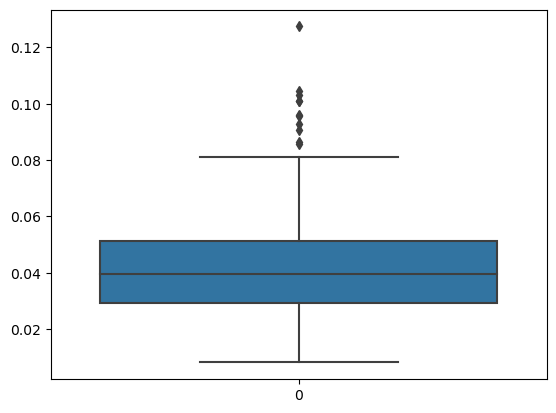

In [48]:
property_crime.describe() * 100


sns.boxplot(property_crime)
plt.show()

In [49]:
property_crime.describe() * 100

count    94800.000000
mean         4.107727
std          1.681169
min          0.812613
25%          2.910991
50%          3.960360
75%          5.112895
max         12.743491
Name: PropertyCrime_pct_lag1, dtype: float64

In [50]:
violent_crime.describe() * 100

count    94800.000000
mean         5.476485
std          3.454552
min          0.430378
25%          2.774075
50%          4.711536
75%          7.467656
max         21.554439
Name: ViolentCrime_pct_lag1, dtype: float64

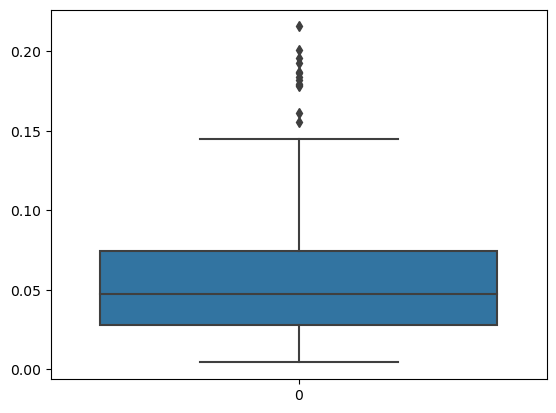

In [51]:



sns.boxplot(violent_crime)
plt.show()

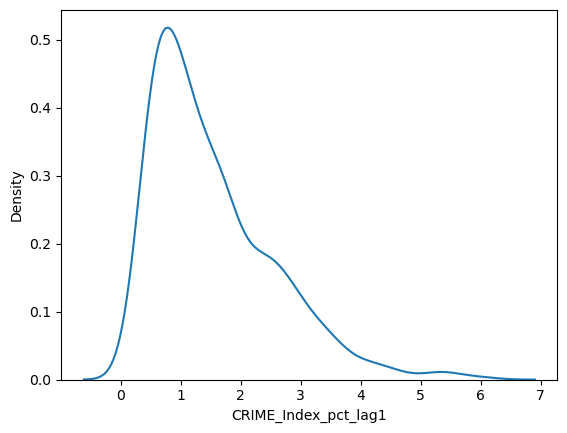

In [52]:
sns.kdeplot(CRIME_Index_pct_lag1)
plt.show()

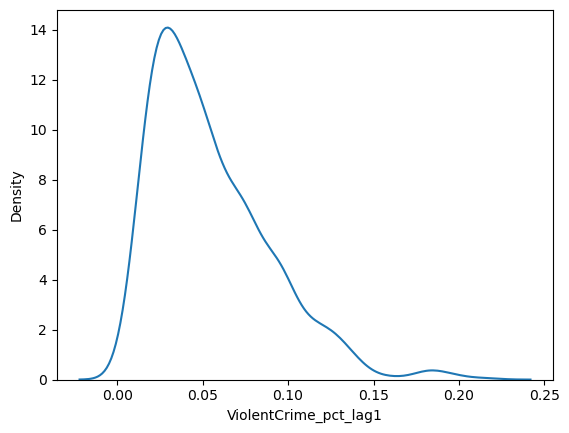

In [53]:
sns.kdeplot(violent_crime)
plt.show()

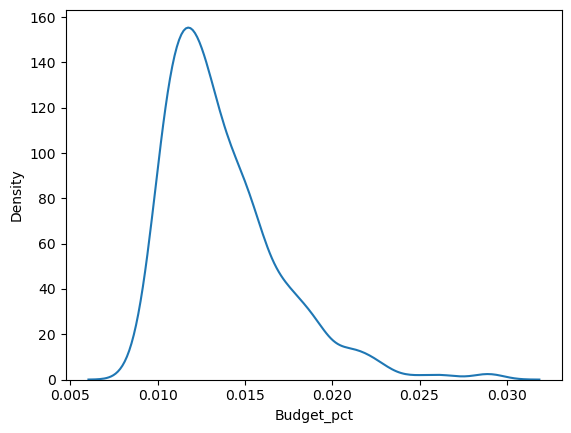

In [54]:
sns.kdeplot(Budget_pct)
plt.show()

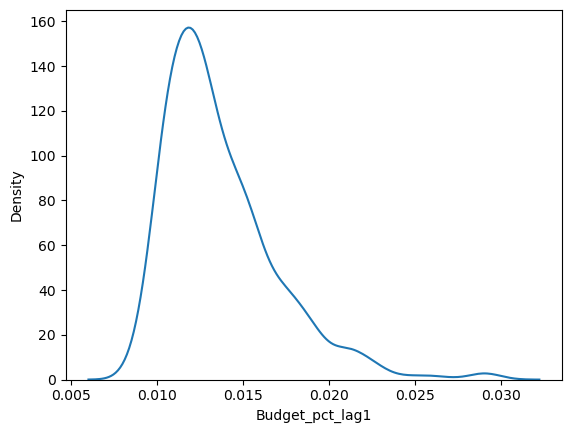

In [55]:
sns.kdeplot(Budget_pct_lag1)
plt.show()

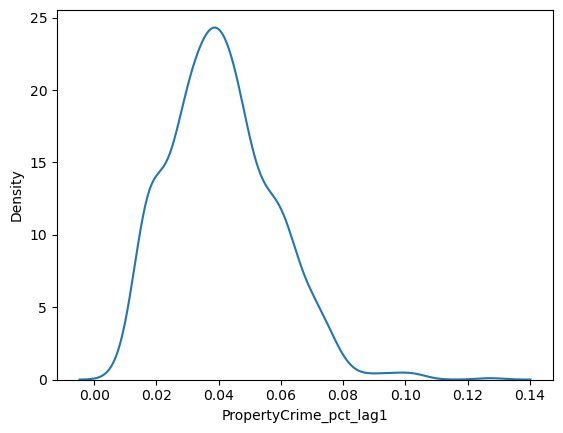

In [56]:
sns.kdeplot(property_crime)
plt.show()

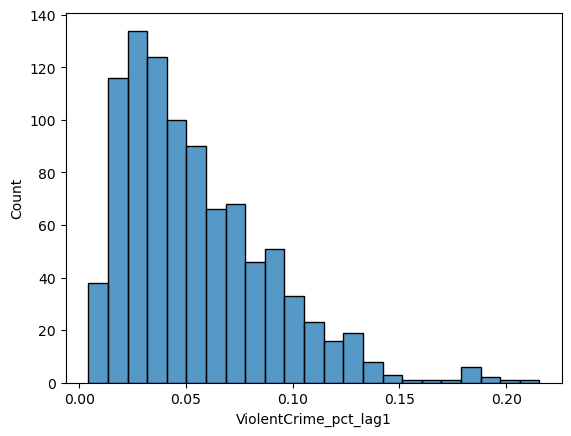

In [57]:
sns.histplot(violent_crime)
plt.show()

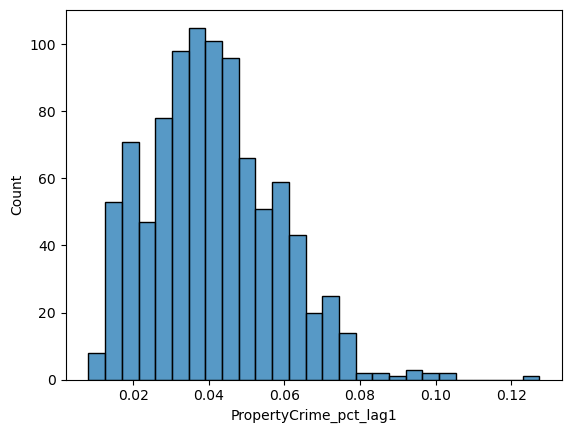

In [58]:
sns.histplot(property_crime)
plt.show()

In [59]:
violent_crime_log = np.log(violent_crime)

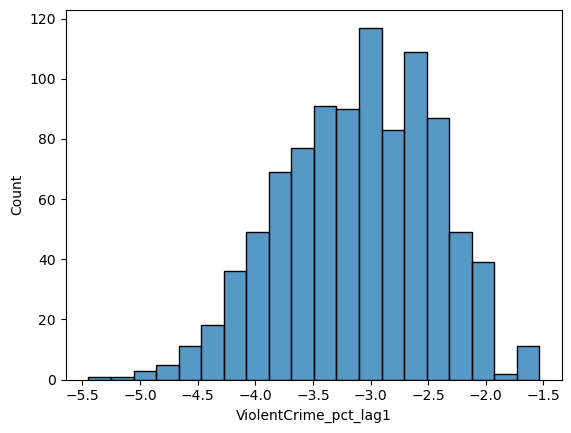

In [60]:
sns.histplot(violent_crime_log)
plt.show()

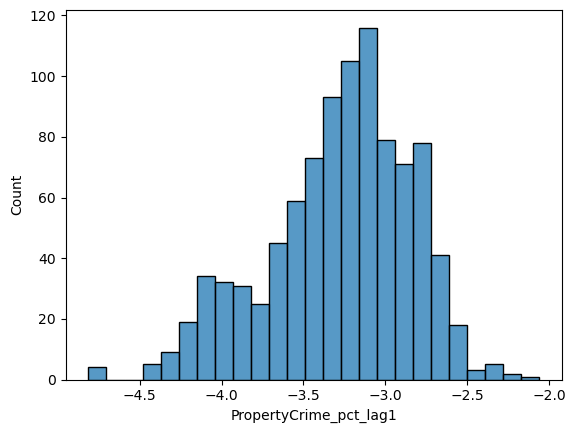

In [61]:
property_crime_log = np.log(property_crime)
sns.histplot(property_crime_log)
plt.show()

In [62]:
from sklearn.preprocessing import StandardScaler

violent_scaler = StandardScaler()

violent_crime_scaled = violent_scaler.fit_transform(pre_ts_analysis_no_2022_clean[['ViolentCrime_pct_lag1']])

property_scaler = StandardScaler()

property_crime_scaled = property_scaler.fit_transform(pre_ts_analysis_no_2022_clean[['PropertyCrime_pct_lag1']])



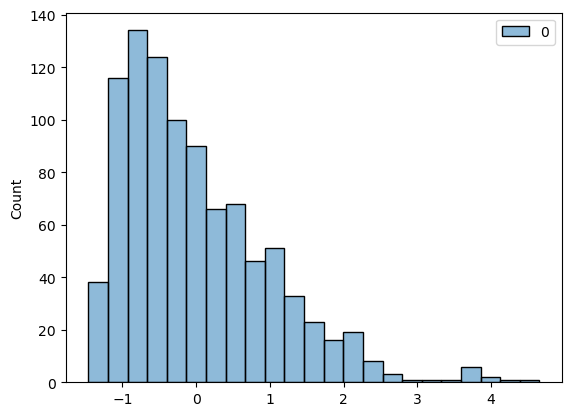

In [63]:
sns.histplot(violent_crime_scaled)
plt.show()

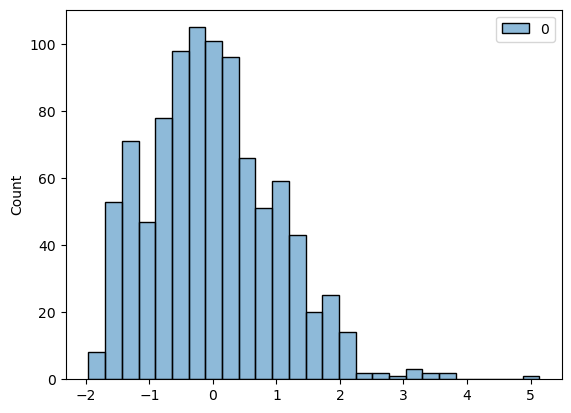

In [64]:
sns.histplot(property_crime_scaled)
plt.show()

In [65]:
from scipy.stats import boxcox

violent_crime_boxcox, lambda_best_fit = boxcox(violent_crime)

In [66]:
lambda_best_fit

0.17474138577912954

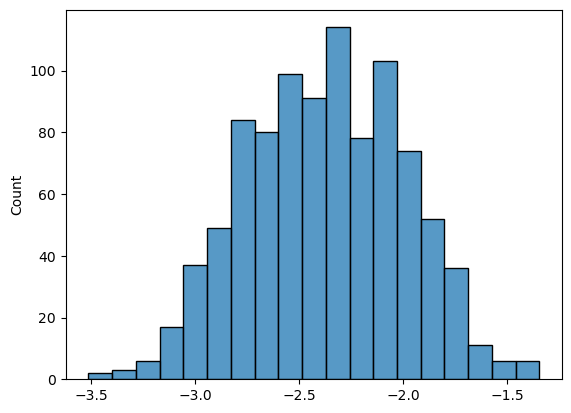

In [67]:
sns.histplot(violent_crime_boxcox)
plt.show()

In [68]:
property_crime_boxcox, lambda_best_fit = boxcox(property_crime)
lambda_best_fit

0.4476968789517491

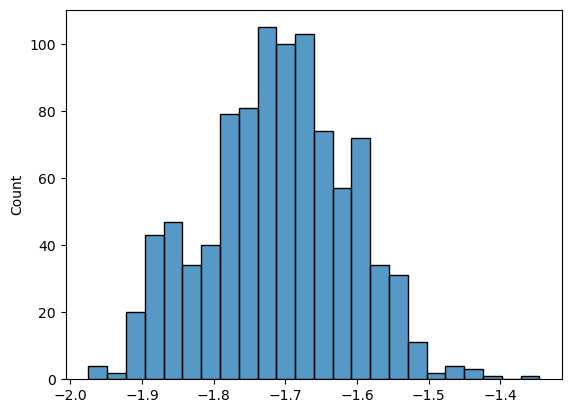

In [69]:
sns.histplot(property_crime_boxcox)
plt.show()

In [70]:
# violent_crime_pct_lag1, property_crime_pct_lag1, crime_index

crime_index_pct_lag1 = pre_ts_analysis_no_2022_clean['CRIME_Index_pct_lag1']
violent_crime_pct_lag1 = pre_ts_analysis_no_2022_clean['ViolentCrime_pct_lag1']
property_crime_pct_lag1 = pre_ts_analysis_no_2022_clean['PropertyCrime_pct_lag1']

#df = pre_ts_analysis_no_2022_clean

# Capture best lambda values from Boxcox transformations across all columns 

lambdas = {}

crime_index_transform, lambdas["crime_index"] = boxcox(crime_index_pct_lag1)
violent_crime_transform, lambdas["violent_crime"] = boxcox(violent_crime_pct_lag1)
property_crime_transform, lambdas["property_crime"] = boxcox(property_crime_pct_lag1)
Budget_pct_transform, lambdas["Budget_pct"] = boxcox(Budget_pct)
Budget_pct_lag1_transform, lambdas["Budget_pct_lag1"] = boxcox(Budget_pct_lag1)

crime_index_transform_log = np.log(crime_index_pct_lag1)
violent_crime_transform_log = np.log(violent_crime_pct_lag1)
property_crime_transform_log = np.log(property_crime_pct_lag1)
Budget_pct_transform_log = np.log(Budget_pct)
Budget_pct_lag1_transform_log = np.log(Budget_pct_lag1)

Budget_pct_Delta_transform_log = np.log(Budget_Delta )

Burglary_pct_transform_log = np.log1p(Burglary_pct)
FELONY_ASSAULT_pct_transform_log = np.log1p(FELONY_ASSAULT_pct)
GRAND_LARCENY_MOTOR_pct_transform_log = np.log1p(GRAND_LARCENY_MOTOR_pct)
MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log = np.log1p(MURDER_NON_NEGL_MANSLAUGHTER_pct)
GRAND_LARCENY_pct_transform_log = np.log1p(GRAND_LARCENY_pct)
RAPE_pct_transform_log = np.log1p(RAPE_pct)
ROBBERY_pct_transform_log = np.log1p(ROBBERY_pct)
#for col in df.columns:
#    df[col], lambdas[col] = boxcox(df[col])

#    print(lambdas)


#Burglary_pct = pre_ts_analysis_no_2022_clean['Burglary_pct_lag1']
#FELONY_ASSAULT_pct = pre_ts_analysis_no_2022_clean['FELONY ASSAULT_pct_lag1']
#GRAND_LARCENY_MOTOR = pre_ts_analysis_no_2022_clean['GRAND LARCENY OF MOTOR VEHICLE_pct_lag1']
#MURDER_NON_NEGL_MANSLAUGHTER_pct = pre_ts_analysis_no_2022_clean['MURDER & NON NEGL. MANSLAUGHTER_pct_lag1']
#GRAND_LARCENY_pct = pre_ts_analysis_no_2022_clean['GRAND LARCENY_pct_lag1']
#RAPE_pct = pre_ts_analysis_no_2022_clean['RAPE_pct_lag1']
#ROBBERY_pct = pre_ts_analysis_no_2022_clean['ROBBERY_pct_lag1']

C:\Users\yinwe\Work_software\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\yinwe\Work_software\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [71]:
lambdas

{'crime_index': 0.08216662296598502,
 'violent_crime': 0.17474138577912954,
 'property_crime': 0.4476968789517491,
 'Budget_pct': -1.2967345344392136,
 'Budget_pct_lag1': -1.2912092934339563}

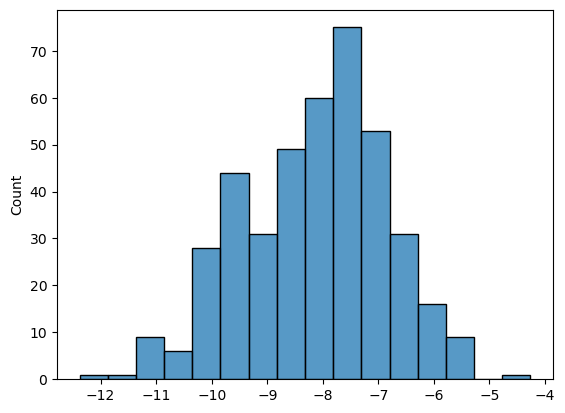

In [72]:
sns.histplot(Budget_pct_Delta_transform_log)
plt.show()

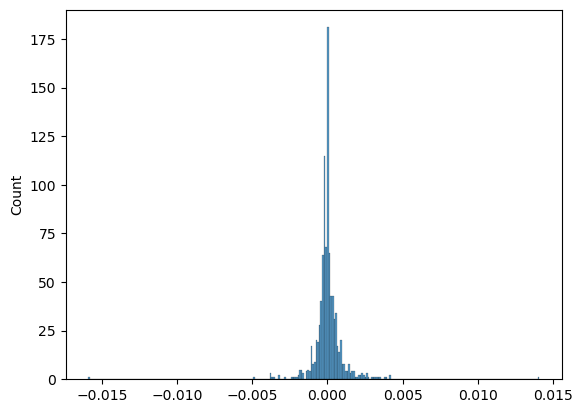

In [73]:
sns.histplot(Budget_Delta)
plt.show()


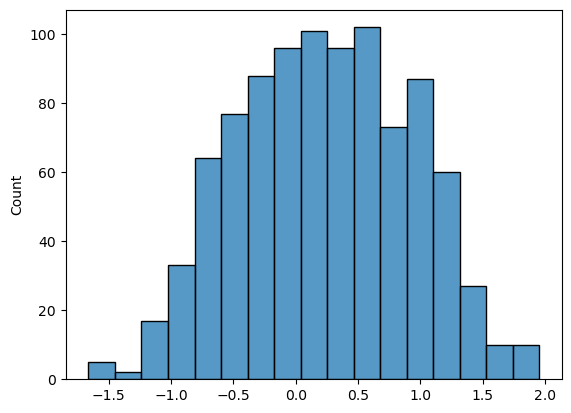

In [74]:
sns.histplot(crime_index_transform)
plt.show()

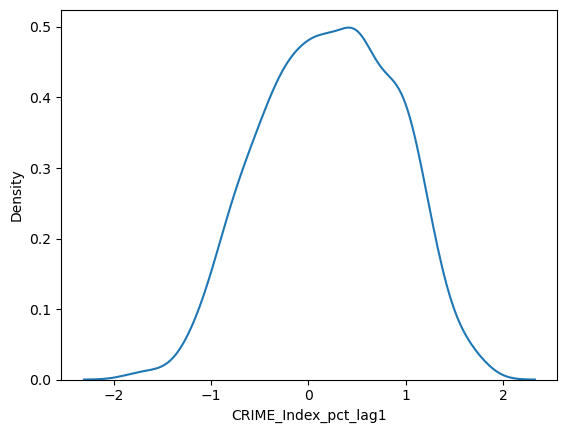

In [75]:
sns.kdeplot(crime_index_transform_log)
plt.show()

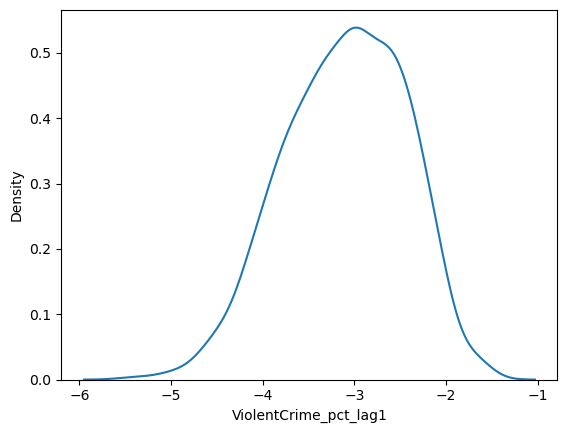

In [76]:
sns.kdeplot(violent_crime_transform_log)
plt.show()

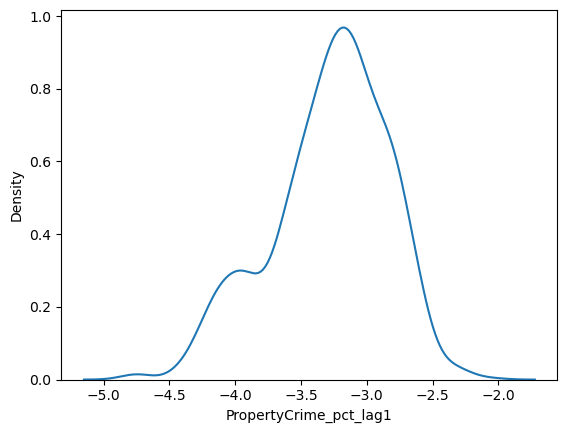

In [77]:
sns.kdeplot(property_crime_transform_log)
plt.show()

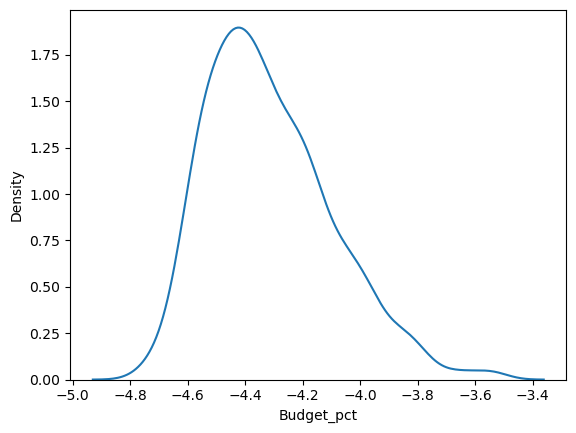

In [78]:
sns.kdeplot(Budget_pct_transform_log)
plt.show()

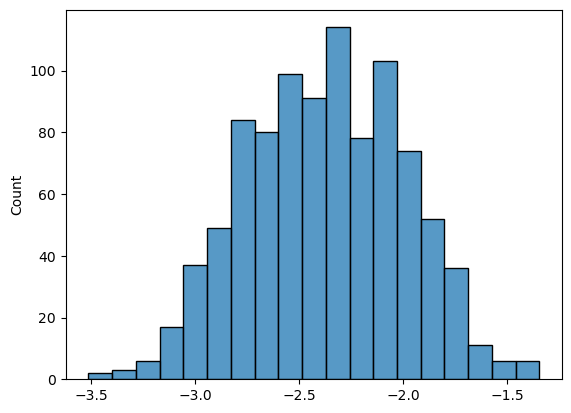

In [79]:
sns.histplot(violent_crime_transform)
plt.show()

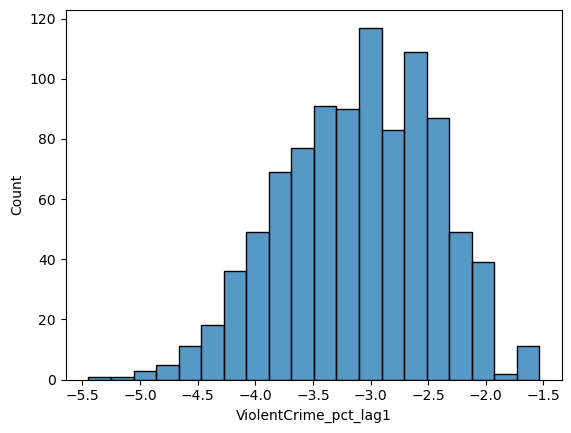

In [80]:
sns.histplot(violent_crime_transform_log)
plt.show()

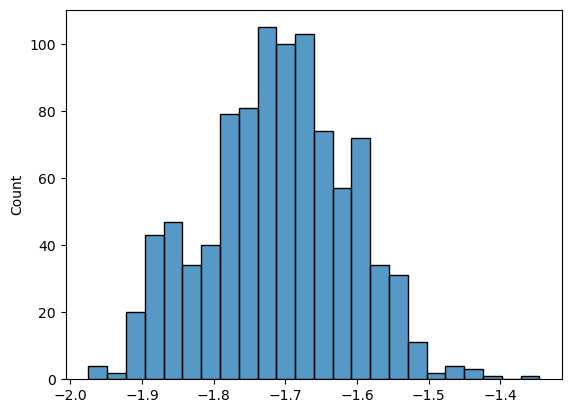

In [81]:
sns.histplot(property_crime_transform)
plt.show()

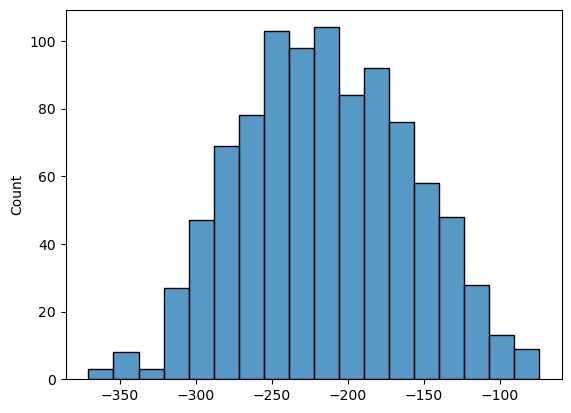

In [82]:
sns.histplot(Budget_pct_transform)
plt.show()

In [83]:
pre_ts_analysis_no_2022_clean

,Year,Precinct,Full Time Positions,Budget,Borough,Citizen_2010,Poverty Rate_2010,Immigration Rates 2010,Budget per Capita,BURGLARY,...,ViolentCrime_pct,ViolentCrime_pct_lag1,PropertyCrime_pct,PropertyCrime_pct_lag1,CRIME_Index_per_capita_lag1_pct,ViolentCrime_per_capita_lag1_pct,PropertyCrime_per_capita_lag1_pct,Annual,Adjusted_Budget_per_capita,Adjusted_Budget_per_capita_lag1
0,2008,1,223,14165270,MANHATTAN SOUTH,44138,6.12%,33.16%,214.52,189,...,0.021394,0.016536,0.046062,0.050877,0.020461,0.008311,0.035416,215.572,288.929817,254.956852
1,2008,5,195,9738430,MANHATTAN SOUTH,37193,24.59%,29.40%,184.85,150,...,0.020833,0.021675,0.023695,0.023574,0.015682,0.013241,0.019580,215.572,236.489360,229.225709
2,2008,6,220,11254960,MANHATTAN SOUTH,50266,6.20%,19.22%,180.87,282,...,0.018233,0.032534,0.046108,0.045836,0.022192,0.013562,0.033177,215.572,234.450033,235.372584
3,2008,7,178,9164428,MANHATTAN SOUTH,43853,29.72%,22.03%,162.95,104,...,0.028337,0.026918,0.019982,0.018151,0.013249,0.015353,0.012359,215.572,210.367927,210.981717
4,2008,9,212,10708169,MANHATTAN SOUTH,58772,21.06%,23.12%,140.08,225,...,0.032511,0.031477,0.038388,0.037396,0.015925,0.012795,0.020250,215.572,179.931881,178.641292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,2020,114,252,20251282,QUEENS NORTH,129728,16.62%,36.02%,99.88,273,...,0.065400,0.058964,0.068714,0.064570,0.009168,0.008350,0.009950,267.693,100.585821,97.711686
944,2020,115,289,17972579,QUEENS NORTH,80034,19.76%,53.35%,104.75,167,...,0.079397,0.096142,0.051324,0.049493,0.009917,0.010865,0.008160,267.693,103.914164,103.806363
945,2020,120,399,26776288,STATEN ISLAND,73854,19.79%,34.39%,237.87,105,...,0.064877,0.044576,0.023723,0.027226,0.009458,0.010354,0.007015,267.693,226.745083,223.724288
946,2020,122,249,18356669,STATEN ISLAND,103552,9.18%,25.49%,132.08,92,...,0.016954,0.032179,0.021933,0.020304,0.003934,0.002858,0.004874,267.693,131.526161,132.337557


In [84]:
# Test OLS on Budget_pct i,t = Violent crime_lag1_i,t + Property_crime_lag1 i, t + Budget_pct i, t-1 

# Assuming pre_ts_analysis_no_2022_clean is the DataFrame with your data
df = pre_ts_analysis_no_2022_clean

# Add a constant column to the DataFrame to account for the intercept term in the regression
df['const'] = 1

#decrease one degree of freedom:
random_precinct = df['Precinct'].sample(n=1).iloc[0]
df = df[df['Precinct'] != random_precinct]



# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'CRIME_Index_pct_lag1']]
y = df['Budget_pct']

# Fit the OLS regression model
model_3 = sm.OLS(y, X).fit()

# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'CRIME_Index_pct_lag1', 'Budget_pct_lag1']]
y = df['Budget_pct']

# Fit the OLS regression model
model_4 = sm.OLS(y, X).fit()


# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'ViolentCrime_pct_lag1', 'PropertyCrime_pct_lag1']]
y = df['Budget_pct']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'ViolentCrime_pct_lag1', 'PropertyCrime_pct_lag1', 'Budget_pct_lag1' ]]
y = df['Budget_pct']

# Fit the OLS regression model
model_2_before_log = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())
print(model_2_before_log.summary())
print(model_3.summary())
print(model_4.summary())





                            OLS Regression Results                            
Dep. Variable:             Budget_pct   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     665.7
Date:                Tue, 20 Feb 2024   Prob (F-statistic):          2.74e-180
Time:                        16:55:58   Log-Likelihood:                 4430.9
No. Observations:                 935   AIC:                            -8856.
Df Residuals:                     932   BIC:                            -8841.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [85]:
GRAND_LARCENY_pct_transform_log

0      0.034438
1      0.014512
2      0.030036
3      0.008205
4      0.020362
         ...   
943    0.019823
944    0.013225
945    0.007296
946    0.006940
947    0.004343
Name: GRAND LARCENY_pct_lag1, Length: 948, dtype: float64

In [86]:
RAPE_pct_transform_log

0      0.005281
1      0.003021
2      0.005281
3      0.005281
4      0.011283
         ...   
943    0.019919
944    0.024548
945    0.013518
946    0.005900
947    0.002364
Name: RAPE_pct_lag1, Length: 948, dtype: float64

In [87]:
ROBBERY_pct_transform_log

0      0.005974
1      0.007043
2      0.009643
3      0.010338
4      0.009643
         ...   
943    0.014103
944    0.018811
945    0.007230
946    0.003083
947    0.000926
Name: ROBBERY_pct_lag1, Length: 948, dtype: float64

In [88]:
MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log

0      0.000000
1      0.004049
2      0.010091
3      0.004049
4      0.000000
         ...   
943    0.006349
944    0.034432
945    0.009509
946    0.018928
947    0.009509
Name: MURDER & NON NEGL. MANSLAUGHTER_pct_lag1, Length: 948, dtype: float64

In [89]:
GRAND_LARCENY_MOTOR_pct_transform_log

0      0.004806
1      0.003131
2      0.005643
3      0.004274
4      0.006783
         ...   
943    0.025280
944    0.023811
945    0.011046
946    0.007128
947    0.004695
Name: GRAND LARCENY OF MOTOR VEHICLE_pct_lag1, Length: 948, dtype: float64

In [90]:
Burglary_pct_transform_log

0      0.010961
1      0.005804
2      0.009639
3      0.005614
4      0.009969
         ...   
943    0.018769
944    0.012011
945    0.008758
946    0.006168
947    0.003089
Name: Burglary_pct_lag1, Length: 948, dtype: float64

In [91]:
FELONY_ASSAULT_pct_transform_log

0      0.005236
1      0.007496
2      0.007381
3      0.007149
4      0.010387
         ...   
943    0.018108
944    0.017122
945    0.014057
946    0.004058
947    0.003108
Name: FELONY ASSAULT_pct_lag1, Length: 948, dtype: float64

In [92]:
# Log transformation
df['crime_index_transform_log'] = crime_index_transform_log
df['violent_crime_transform_log'] = violent_crime_transform_log
df['property_crime_transform_log'] = property_crime_transform_log
df['Budget_pct_transform_log'] = Budget_pct_transform_log
df['Budget_pct_lag1_transform_log'] = Budget_pct_lag1_transform_log
df['Budget_pct_Delta_transform_log'] = Budget_pct_Delta_transform_log
df['Budget_Delta'] = Budget_Delta

df['Burglary_pct_transform_log'] = Burglary_pct_transform_log
df['FELONY_ASSAULT_pct_transform_log'] = FELONY_ASSAULT_pct_transform_log
df['GRAND_LARCENY_MOTOR_pct_transform_log'] = GRAND_LARCENY_MOTOR_pct_transform_log
df['MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log'] = MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log
df['GRAND_LARCENY_pct_transform_log'] = GRAND_LARCENY_pct_transform_log
df['RAPE_pct_transform_log'] = RAPE_pct_transform_log
df['ROBBERY_pct_transform_log'] = ROBBERY_pct_transform_log

# Use the Log transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'crime_index_transform_log']]
y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model_3 = sm.OLS(y, X).fit()


# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'crime_index_transform_log', 'Budget_pct_lag1_transform_log']]
y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model_4 = sm.OLS(y, X).fit()


# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'violent_crime_transform_log', 'property_crime_transform_log']]
y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'violent_crime_transform_log', 'property_crime_transform_log', 'Budget_pct_lag1_transform_log' ]]
y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model_2 = sm.OLS(y, X).fit()

# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'violent_crime_transform_log', 'property_crime_transform_log', 'Budget_pct_lag1_transform_log' ]]
y = df['Budget_Delta']

# Fit the OLS regression model
model_3 = sm.OLS(y, X).fit()


# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['const', 'Burglary_pct_transform_log', 'FELONY_ASSAULT_pct_transform_log', 'GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log','GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log', 'ROBBERY_pct_transform_log','Budget_pct_lag1_transform_log']]
y = df['Budget_pct_transform_log']

# # Fit the OLS regression model
model_6 = sm.OLS(y, X).fit()


# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['Burglary_pct_transform_log', 'FELONY_ASSAULT_pct_transform_log', 'GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log','GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log', 'ROBBERY_pct_transform_log' ]]
y = df['Budget_pct_transform_log']

# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Standardize the dependent variable
y_standardized = (y - y.mean()) / y.std()

# Add a constant to the model (intercept)
X_standardized = sm.add_constant(X_standardized)

# Fit the OLS model with standardized variables
model_standardized = sm.OLS(y_standardized, X_standardized).fit()




# Print the regression results
print(model.summary())
print(model_2.summary())
print(model_3.summary())
print(model_6.summary())
print(model_standardized.summary())
# print(model_3.summary())
# print(model_4.summary())
# crime_index_transform_log = np.log(crime_index_pct_lag1)
# violent_crime_transform_log = np.log(violent_crime_pct_lag1)
# property_crime_transform_log = np.log(property_crime_pct_lag1)
# Budget_pct_transform_log = np.log(Budget_pct)
# Budget_pct_lag1_transform_log = np.log(Budget_pct_lag1)



                               OLS Regression Results                               
Dep. Variable:     Budget_pct_transform_log   R-squared:                       0.532
Model:                                  OLS   Adj. R-squared:                  0.531
Method:                       Least Squares   F-statistic:                     529.4
Date:                      Tue, 20 Feb 2024   Prob (F-statistic):          2.53e-154
Time:                              16:55:58   Log-Likelihood:                 445.61
No. Observations:                       935   AIC:                            -885.2
Df Residuals:                           932   BIC:                            -870.7
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

C:\Users\yinwe\AppData\Local\Temp\ipykernel_17328\1177714605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['crime_index_transform_log'] = crime_index_transform_log
C:\Users\yinwe\AppData\Local\Temp\ipykernel_17328\1177714605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['violent_crime_transform_log'] = violent_crime_transform_log
C:\Users\yinwe\AppData\Local\Temp\ipykernel_17328\1177714605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [93]:
df

,Year,Precinct,Full Time Positions,Budget,Borough,Citizen_2010,Poverty Rate_2010,Immigration Rates 2010,Budget per Capita,BURGLARY,...,Budget_pct_lag1_transform_log,Budget_pct_Delta_transform_log,Budget_Delta,Burglary_pct_transform_log,FELONY_ASSAULT_pct_transform_log,GRAND_LARCENY_MOTOR_pct_transform_log,MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log,GRAND_LARCENY_pct_transform_log,RAPE_pct_transform_log,ROBBERY_pct_transform_log
0,2008,1,223,14165270,MANHATTAN SOUTH,44138,6.12%,33.16%,214.52,189,...,-4.307733,-6.321186,0.001798,0.010961,0.005236,0.004806,0.000000,0.034438,0.005281,0.005974
1,2008,5,195,9738430,MANHATTAN SOUTH,37193,24.59%,29.40%,184.85,150,...,-4.555682,NaN,-0.000015,0.005804,0.007496,0.003131,0.004049,0.014512,0.003021,0.007043
2,2008,6,220,11254960,MANHATTAN SOUTH,50266,6.20%,19.22%,180.87,282,...,-4.383470,NaN,-0.000356,0.009639,0.007381,0.005643,0.010091,0.030036,0.005281,0.009643
3,2008,7,178,9164428,MANHATTAN SOUTH,43853,29.72%,22.03%,162.95,104,...,-4.588949,NaN,-0.000290,0.005614,0.007149,0.004274,0.004049,0.008205,0.005281,0.010338
4,2008,9,212,10708169,MANHATTAN SOUTH,58772,21.06%,23.12%,140.08,225,...,-4.439830,NaN,-0.000261,0.009969,0.010387,0.006783,0.000000,0.020362,0.011283,0.009643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,2020,114,252,20251282,QUEENS NORTH,129728,16.62%,36.02%,99.88,273,...,-4.158363,-7.283904,0.000687,0.018769,0.018108,0.025280,0.006349,0.019823,0.019919,0.014103
944,2020,115,289,17972579,QUEENS NORTH,80034,19.76%,53.35%,104.75,167,...,-4.251245,-8.348155,0.000237,0.012011,0.017122,0.023811,0.034432,0.013225,0.024548,0.018811
945,2020,120,399,26776288,STATEN ISLAND,73854,19.79%,34.39%,237.87,105,...,-3.868353,-7.285953,0.000685,0.008758,0.014057,0.011046,0.009509,0.007296,0.013518,0.007230
946,2020,122,249,18356669,STATEN ISLAND,103552,9.18%,25.49%,132.08,92,...,-4.222543,-8.936333,0.000132,0.006168,0.004058,0.007128,0.018928,0.006940,0.005900,0.003083


In [94]:
# Prepare your independent variables (X) and the dependent variable (y)
X = df[['const', 'Burglary_pct_transform_log', 'FELONY_ASSAULT_pct_transform_log', 'GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log', 'GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log', 'ROBBERY_pct_transform_log', 'Budget_pct_lag1_transform_log']]
y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Calculate VIF for each independent variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                                         Variable          VIF
0                                           const  1215.627885
1                      Burglary_pct_transform_log     3.851698
2                FELONY_ASSAULT_pct_transform_log    10.123740
3           GRAND_LARCENY_MOTOR_pct_transform_log     3.083020
4  MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log     2.901489
5                 GRAND_LARCENY_pct_transform_log     1.332321
6                          RAPE_pct_transform_log     3.685808
7                       ROBBERY_pct_transform_log     8.799049
8                   Budget_pct_lag1_transform_log     2.673396


In [95]:
# Assuming 'df' is your DataFrame and it has been loaded properly with the required columns.

# Prepare your independent variables (X) without the constant
independent_vars = ['Burglary_pct_transform_log', 'FELONY_ASSAULT_pct_transform_log', 'GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log', 'GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log', 'ROBBERY_pct_transform_log', 'Budget_pct_lag1_transform_log']
X = df[independent_vars]
# We add a constant to the model as a best practice for OLS regression
X = sm.add_constant(X)

y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars  # Excludes the constant
vif_data["VIF"] = [variance_inflation_factor(X[independent_vars].values, i) for i in range(X[independent_vars].shape[1])]

print(vif_data)

                                         Variable        VIF
0                      Burglary_pct_transform_log  21.564504
1                FELONY_ASSAULT_pct_transform_log  31.774328
2           GRAND_LARCENY_MOTOR_pct_transform_log  10.993180
3  MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log   6.283190
4                 GRAND_LARCENY_pct_transform_log   6.591477
5                          RAPE_pct_transform_log  13.343925
6                       ROBBERY_pct_transform_log  35.869753
7                   Budget_pct_lag1_transform_log   7.125012


In [96]:
# Remove ROBBERY_pct_transform_log
# Prepare your independent variables (X) without the constant
independent_vars = ['Burglary_pct_transform_log', 'FELONY_ASSAULT_pct_transform_log', 'GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log', 'GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log',  'Budget_pct_lag1_transform_log']
X = df[independent_vars]
# We add a constant to the model as a best practice for OLS regression
X = sm.add_constant(X)

y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars  # Excludes the constant
vif_data["VIF"] = [variance_inflation_factor(X[independent_vars].values, i) for i in range(X[independent_vars].shape[1])]

print(vif_data)

                                         Variable        VIF
0                      Burglary_pct_transform_log  20.084590
1                FELONY_ASSAULT_pct_transform_log  17.139966
2           GRAND_LARCENY_MOTOR_pct_transform_log  10.989187
3  MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log   6.251250
4                 GRAND_LARCENY_pct_transform_log   6.561328
5                          RAPE_pct_transform_log  12.902277
6                   Budget_pct_lag1_transform_log   7.117634


In [97]:
# Remove ROBBERY_pct_transform_log + Burglary_pct_transform_log
# Prepare your independent variables (X) without the constant
independent_vars = ['FELONY_ASSAULT_pct_transform_log', 'GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log', 'GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log',  'Budget_pct_lag1_transform_log']
X = df[independent_vars]
# We add a constant to the model as a best practice for OLS regression
X = sm.add_constant(X)

y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars  # Excludes the constant
vif_data["VIF"] = [variance_inflation_factor(X[independent_vars].values, i) for i in range(X[independent_vars].shape[1])]

print(vif_data)

                                         Variable        VIF
0                FELONY_ASSAULT_pct_transform_log  16.585621
1           GRAND_LARCENY_MOTOR_pct_transform_log   5.645982
2  MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log   6.250552
3                 GRAND_LARCENY_pct_transform_log   5.438735
4                          RAPE_pct_transform_log  12.902184
5                   Budget_pct_lag1_transform_log   6.875171


In [98]:
# Remove ROBBERY_pct_transform_log + Burglary_pct_transform_log + FELONY_ASSAULT_pct_transform_log
# Prepare your independent variables (X) without the constant
independent_vars = [ 'GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log', 'GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log',  'Budget_pct_lag1_transform_log']
X = df[independent_vars]
# We add a constant to the model as a best practice for OLS regression
X = sm.add_constant(X)

y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars  # Excludes the constant
vif_data["VIF"] = [variance_inflation_factor(X[independent_vars].values, i) for i in range(X[independent_vars].shape[1])]

print(vif_data)

                                         Variable       VIF
0           GRAND_LARCENY_MOTOR_pct_transform_log  5.530394
1  MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log  4.255408
2                 GRAND_LARCENY_pct_transform_log  5.427170
3                          RAPE_pct_transform_log  8.341765
4                   Budget_pct_lag1_transform_log  6.852126


In [99]:
independent_vars = [ 'GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log', 'GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log',  'Budget_pct_lag1_transform_log']
X = df[independent_vars]
# We add a constant to the model as a best practice for OLS regression
X = sm.add_constant(X)

y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     Budget_pct_transform_log   R-squared:                       0.922
Model:                                  OLS   Adj. R-squared:                  0.921
Method:                       Least Squares   F-statistic:                     2190.
Date:                      Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                              16:55:58   Log-Likelihood:                 1282.1
No. Observations:                       935   AIC:                            -2552.
Df Residuals:                           929   BIC:                            -2523.
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [100]:
# Assuming 'df' is your DataFrame and 'Budget_pct_transform_log' is the column of interest
y_sd = np.std(df['Budget_pct_transform_log'], ddof=1) # ddof=1 to use sample standard deviation
print(f"Standard Deviation of y: {y_sd}")

Standard Deviation of y: 0.2196940721780164


In [101]:
# Assuming 'df' is your DataFrame with the required data.
independent_vars = ['GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log', 'GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log', 'Budget_pct_lag1_transform_log']
X = df[independent_vars]
X = sm.add_constant(X)  # add a constant to the model

y = df['Budget_pct_transform_log']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Now calculate the standard deviations for the independent variables and the dependent variable
sd_x = X.std()
sd_y = y.std()

# Get the unstandardized coefficients (excluding the constant)
coefficients = model.params[1:]  # Exclude the constant term

# Compute the standardized coefficients
standardized_coefficients = coefficients * sd_x[independent_vars] / sd_y

# Display the standardized coefficients
print(standardized_coefficients)

GRAND_LARCENY_MOTOR_pct_transform_log             0.019952
MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log    0.033566
GRAND_LARCENY_pct_transform_log                   0.014684
RAPE_pct_transform_log                            0.044527
Budget_pct_lag1_transform_log                     0.893449
dtype: float64


In [102]:
sd_y

0.2196940721780164

In [103]:
sd_x

const                                             0.000000
GRAND_LARCENY_MOTOR_pct_transform_log             0.008378
MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log    0.012337
GRAND_LARCENY_pct_transform_log                   0.006487
RAPE_pct_transform_log                            0.008207
Budget_pct_lag1_transform_log                     0.219978
dtype: float64

In [104]:
# Use the transformed variables and Budget_pct lagged by one period as independent variables
X = df[['GRAND_LARCENY_MOTOR_pct_transform_log', 'MURDER_NON_NEGL_MANSLAUGHTER_pct_transform_log','GRAND_LARCENY_pct_transform_log', 'RAPE_pct_transform_log', 'Budget_pct_lag1_transform_log'  ]]
y = df['Budget_pct_transform_log']

# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Standardize the dependent variable
y_standardized = (y - y.mean()) / y.std()

# Add a constant to the model (intercept)
X_standardized = sm.add_constant(X_standardized)

# Fit the OLS model with standardized variables
model_standardized = sm.OLS(y_standardized, X_standardized).fit()

print(model_standardized.summary())

                               OLS Regression Results                               
Dep. Variable:     Budget_pct_transform_log   R-squared:                       0.922
Model:                                  OLS   Adj. R-squared:                  0.921
Method:                       Least Squares   F-statistic:                     2190.
Date:                      Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                              16:55:58   Log-Likelihood:                -134.87
No. Observations:                       935   AIC:                             281.7
Df Residuals:                           929   BIC:                             310.8
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------